# LA Port Ship Track Analysis  
This notebook examines the graphical structure of dependencies between ship tracks traversing the LA Port region over a day.

In [1975]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import random
import datetime

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.GraphUtils import GraphUtils

import networkx as nx
from pyvis.network import Network 

In [2]:
# Function to draw tracks 
import descartes
import geopandas as gpd
import fiona
from shapely.geometry import Point, LineString, Polygon

%matplotlib inline

def draw_tracks(data, mmsi_list):
    data = data[data.MMSI.isin(mmsi_list)]
    points = [Point(x, y) for x, y in zip(data.LON, data.LAT)]
    points_df = gpd.GeoDataFrame(data, geometry=points, crs ="EPSG:4326")

    # treat each `ID` group of points as a line
    lines = points_df.groupby(['MMSI'])['geometry'].apply(lambda x:  LineString(x.tolist()))
    
    # store as a GeodataFrame and add 'ID' as a column (currently stored as the 'index')
    lines = gpd.GeoDataFrame(lines, geometry='geometry', crs="EPSG:4326") 
    lines.reset_index(inplace=True)
    lines.plot(column='MMSI', categorical=True, legend=True)

def draw_all_tracks(data):
    all_ships = list(data.columns.values)
    draw_tracks(data, all_ships)

def prepare_data_for_vis(data):
    uniques = np.unique(data.MMSI, return_counts=True)
    index_to_remove = list(np.where(uniques[1] == 1)[0])
    to_remove = uniques[0][index_to_remove]
    return data[data.MMSI.isin(to_remove) == False]

### Initial Data Cleaning

In [1636]:
full_la_data = pd.read_csv("../data/AIS_la_port.csv", low_memory=False)

In [1866]:
cols = ["MMSI", "BaseDateTime", "LAT", "LON", "SOG", "COG", "Heading", 'VesselType']
la_data = full_la_data[cols]

In [1867]:
# Get only cargo ships
la_data = la_data.copy()[(la_data.VesselType >= 70) & (la_data.VesselType < 90)]
la_data.drop(columns=['VesselType'], axis=1, inplace=True)

In [1868]:
# Convert time string to timestamp
la_data['BaseDateTime'] = pd.to_datetime(la_data['BaseDateTime'], format='%Y-%m-%dT%H:%M:%S')

In [1869]:
len(la_data.MMSI.unique())

60

In [1870]:
# Remove entries where the ship is not moving
la_data = la_data[la_data.SOG >= .5]
#cog_la = la_data.reset_index(drop=True)
#cog_la = cog_la.drop(['LAT', 'LON', 'SOG', 'Heading'], axis=1)

In [1871]:
len(la_data.MMSI.unique())

43

In [1872]:
#for mmsi in la_data.MMSI.unique(): 
#    print(la_data[la_data.MMSI == mmsi].shape[0])

In [1873]:
# Only keep mmsi that have more than 100 records (sparse tracks)
for mmsi in la_data.MMSI.unique(): 
    if la_data[la_data.MMSI == mmsi].shape[0] < 50:
        la_data = la_data[la_data.MMSI != mmsi]

In [1874]:
len(la_data.MMSI.unique())

37

In [1875]:
track = la_data[la_data.MMSI==mmsi].sort_values("BaseDateTime")
track = track.set_index("BaseDateTime")
track['time_diff'] = track.index.to_series().diff().dt.seconds.div(60, fill_value=0)
track.time_diff.mean()

1.4969357249626307

In [1876]:
#track.resample("3T").mean()#.shape[0] - track.resample("3T").mean().isna().sum()[0]

In [1877]:
problem_tracks = [538003241, 303294000, 367006790, 636013644, 367776050, 577364000, 
                 636015359, 477737900]

In [1878]:
tracks = []
for mmsi in la_data.MMSI.unique():
    track = la_data[la_data.MMSI==mmsi].sort_values("BaseDateTime")
    track = track.set_index("BaseDateTime")
    track['time_diff'] = track.index.to_series().diff().dt.seconds.div(60, fill_value=0)
    if track.time_diff.mean() < 2.0:
        track = track.drop(["time_diff"], axis=1)
        track = track.resample("3T").mean().interpolate()
        tracks.append(track)
    else:
        la_data = la_data[la_data.MMSI != mmsi]

In [1879]:
len(la_data.MMSI.unique())

27

In [1921]:
tracks_mmsi = []
for track in tracks:
    tracks_mmsi.append(track.MMSI.unique()[0])

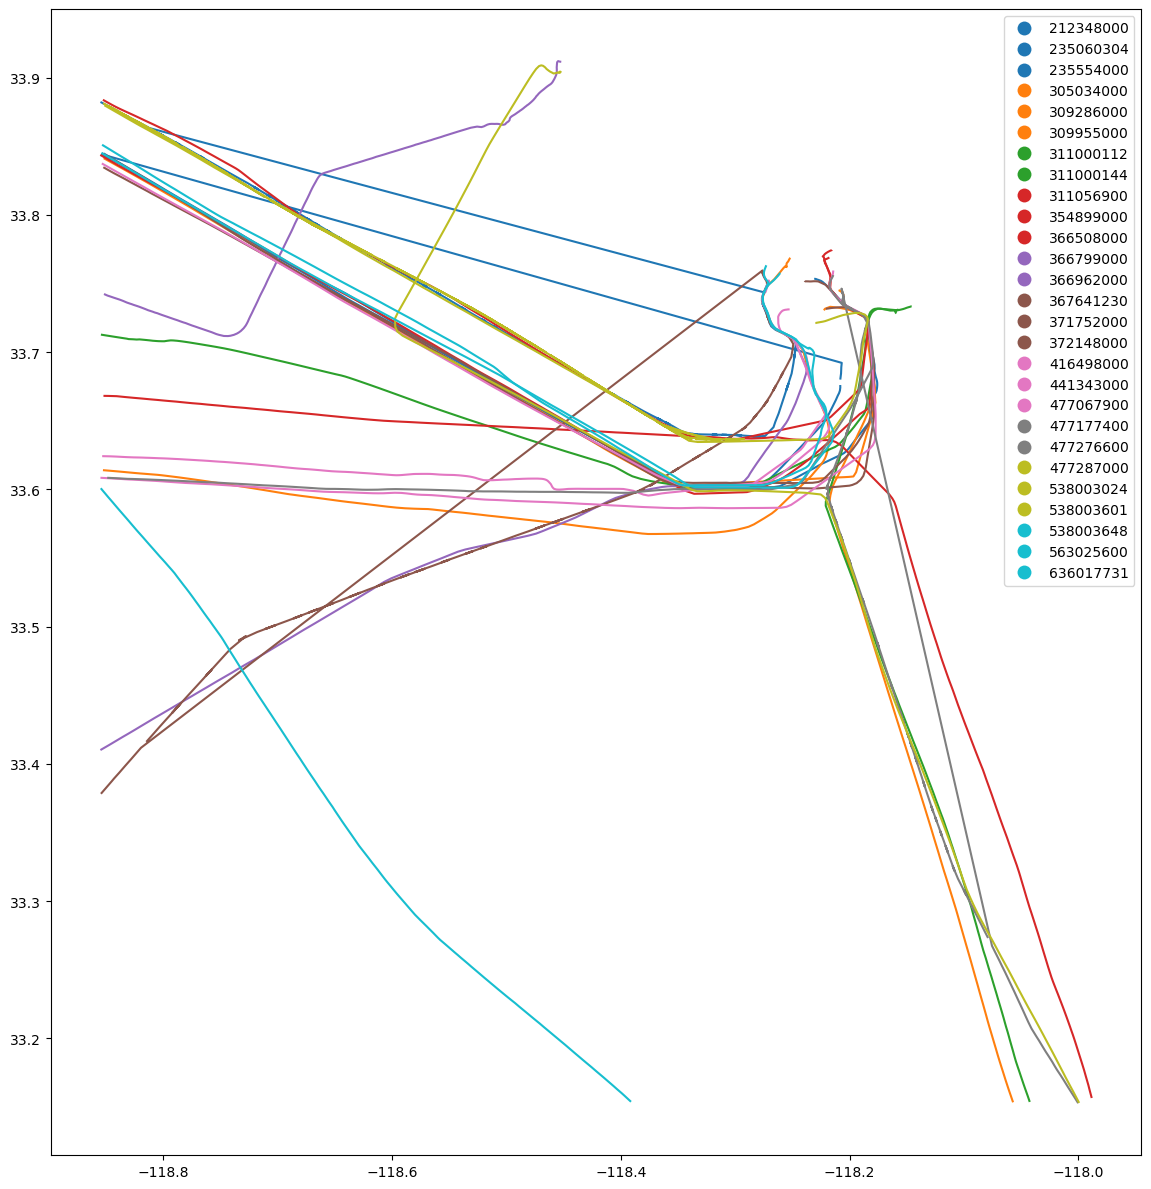

In [1880]:
all_ships = list(la_data.MMSI.unique())
draw_tracks(la_data, all_ships)

In [1881]:
tracks[0].head(20)

MMSI        LAT         LON       SOG        COG  \
BaseDateTime                                                                   
2020-01-02 03:09:00  309955000.0  33.613820 -118.850515  8.050000  94.650000   
2020-01-02 03:12:00  309955000.0  33.613270 -118.842660  8.000000  94.800000   
2020-01-02 03:15:00  309955000.0  33.612595 -118.833680  8.100000  95.650000   
2020-01-02 03:18:00  309955000.0  33.612090 -118.827165  8.050000  94.700000   
2020-01-02 03:21:00  309955000.0  33.611377 -118.817060  8.000000  94.166667   
2020-01-02 03:24:00  309955000.0  33.610890 -118.809730  8.000000  94.700000   
2020-01-02 03:27:00  309955000.0  33.610450 -118.803535  8.000000  95.600000   
2020-01-02 03:30:00  309955000.0  33.609665 -118.795500  8.050000  97.150000   
2020-01-02 03:33:00  309955000.0  33.608683 -118.786163  8.000000  97.266667   
2020-01-02 03:36:00  309955000.0  33.607580 -118.776430  8.000000  98.200000   
2020-01-02 03:39:00  309955000.0  33.606670 -118.768730  8.000000  98.100000   
2020-01-02 03:42:00  309955000.0  33.605720 -118.760930  8.100000  98.700000   
2020-01-02 03:45:00  309955000.0  33.604817 -118.753820  8.100000  98.933333   
2020-01-02 03:48:00  309955000.0  33.603885 -118.746235  8.100000  98.250000   
2020-01-02 03:51:00  309955000.0  33.602690 -118.736490  8.000000  98.500000   
2020-01-02 03:54:00  309955000.0  33.601920 -118.730300  8.000000  99.000000   
2020-01-02 03:57:00  309955000.0  33.600565 -118.719960  8.000000  98.850000   
2020-01-02 04:00:00  309955000.0  33.599820 -118.714507  7.900000  98.900000   
2020-01-02 04:03:00  309955000.0  33.598557 -118.705290  7.933333  99.200000   
2020-01-02 04:06:00  309955000.0  33.597550 -118.698070  7.950000  99.200000   

                     Heading  
BaseDateTime                  
2020-01-02 03:09:00     97.0  
2020-01-02 03:12:00     97.0  
2020-01-02 03:15:00     97.0  
2020-01-02 03:18:00     97.0  
2020-01-02 03:21:00     97.0  
2020-01-02 03:24:00     97.0  
2020-01-02 03:27:00     98.5  
2020-01-02 03:30:00     99.0  
2020-01-02 03:33:00     99.0  
2020-01-02 03:36:00     99.0  
2020-01-02 03:39:00     99.0  
2020-01-02 03:42:00     99.0  
2020-01-02 03:45:00     99.0  
2020-01-02 03:48:00     99.0  
2020-01-02 03:51:00     99.0  
2020-01-02 03:54:00     99.0  
2020-01-02 03:57:00     99.0  
2020-01-02 04:00:00     99.0  
2020-01-02 04:03:00     99.0  
2020-01-02 04:06:00     99.0

### Notes on Cleaning  
1. The first step I took to get clean and dense tracks was to remove any records where the SOG was below .5. This essentially means remove any record where a ship was moving very slowly, almost not moving. This actually eliminated 17 ships completely from the dataset. I suspect it was the ships that were anchored and just floating sporatically. This was confirmed manually.
2. The second step was to remove sparse records. There are different ways to do this and I should confirm with David what he thinks is best. Essentially, I just removed any ships that had less than 100 records. In my data exploration, I found some ships had very sparse and few records. I did not see a point in cleaning these records as there was too much missing data to interpolate. I could have potentially removed only the ships that had few records, and that were far apart in time. This step removed 9 additional tracks.
3. The third step I again checked for sparsity, this time sparse over time. I checked if each track had an average time difference between each record of under 2. I found in my data exploration that most of the dense single tracks had average time differences of around 1.5. This removed a further 7 tracks.
4. Lastly, I binned each tracks values into 3 minute bins and took the average of any timestamps within that bin. This resulted in very dense tracks, with few missing values. I linearly interpolated the missing values because I felt confident that there was few bins which had missing values. 

**IDEA**  
It's really tricky trying to get the intersection of two tracks that may not overlap at all. However, we don't want to just fill nan values with zero for positions that don't overlap, so we would need to do an intersection. It seems like it may be safe to assume that when a track stops reporting AIS, it's lon and lat stay the same? In this case, we could interpolate the missing values with the last lat, lon value that was recorded. This may inflate the correlation as well though. 

## Creating a graph from cleaned tracks

In [1940]:
correlations = {}

In [1943]:
for track_1 in tracks:
    for track_2 in tracks:
        if track_1.MMSI.unique()[0] != track_2.MMSI.unique()[0]:
            df = pd.concat([pd.DataFrame(track_1.COG), 
                            pd.DataFrame(track_2.COG).rename(
                                columns={"COG":"COG_1"})], axis=1).dropna()
            corr = df.COG.corr(df.COG_1)
            correlations[(track_1.MMSI.unique()[0], track_2.MMSI.unique()[0])] = corr
    

/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/conda/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)


In [2023]:
G = nx.Graph(notebook=True)
tracks_mmsi = [int(mmsi) for mmsi in tracks_mmsi]
track_titles = [str(mmsi) for mmsi in tracks_mmsi]
for mmsi in tracks_mmsi:
    G.add_node(mmsi, size=30, title=str(mmsi))
for k, v in correlations.items():
    if not np.isnan(v) and np.abs(v) > .3:
        G.add_edge(int(k[0]), int(k[1]), title=str(v))

In [2024]:
g = Network(notebook=True)
# populates the nodes and edges data structures
g.from_nx(G)
g.show('nx.html')

nx.html


### Creating the first graph

In [1860]:
#data = la_data.copy()
data = la_data
data = data.set_index('BaseDateTime')
data = data.sort_index()

In [1861]:
tracks = data.pivot_table(values='COG', index=data.index, columns='MMSI', aggfunc='first')
tracks = tracks.fillna(0)

In [1862]:
tracks = tracks.resample("2T").mean()
#tracks = tracks.fillna(0)

In [1863]:
graph = pc(tracks.values)
cols = list(tracks.columns.values)
graph.draw_pydot_graph(labels=cols)

AssertionError: Input data contains NaN. Please check.

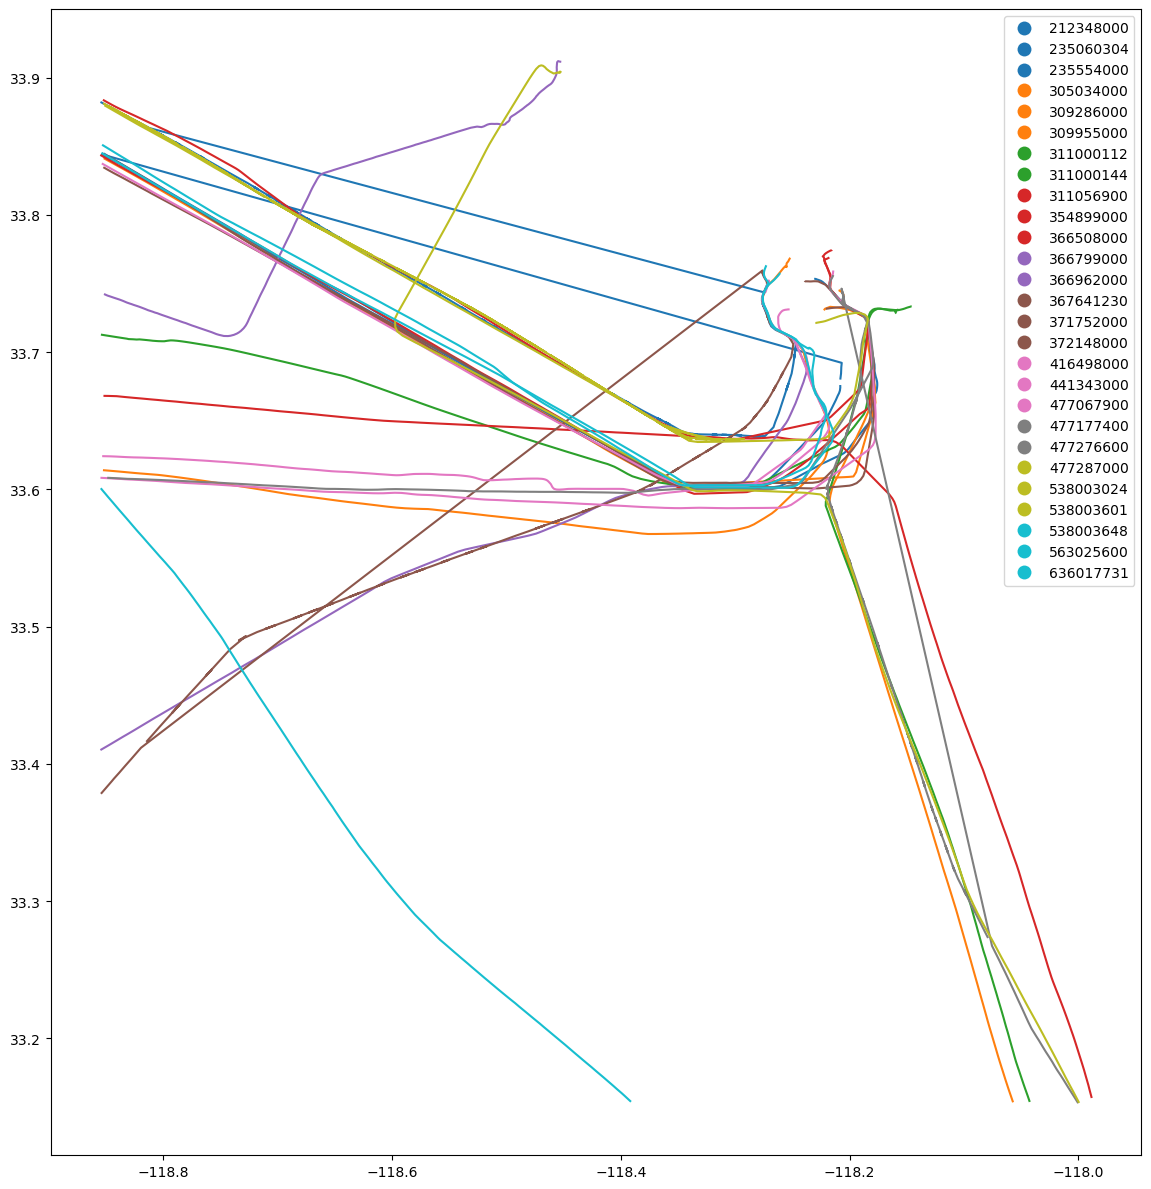

In [1668]:
# All tracks shown
all_ships = list(tracks.columns.values)
draw_tracks(la_data, all_ships)

### Graph for tracks from morning hours  
Here we just look at a portion of the tracks during a set amount of time in the morning hours

In [13]:
start_time = datetime.datetime.strptime('2020-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
end_time = datetime.datetime.strptime('2020-01-01 12:00:00', '%Y-%m-%d %H:%M:%S')

In [14]:
mask = (tracks.index > start_time) & (tracks.index < end_time)

In [15]:
morning_tracks = tracks[mask]

In [16]:
# remove tracks with all constants
nunique = morning_tracks.nunique()
constant_cols = nunique[nunique == 1].index
morning_tracks = morning_tracks.drop(constant_cols, axis=1)

  0%|          | 0/31 [00:00<?, ?it/s]

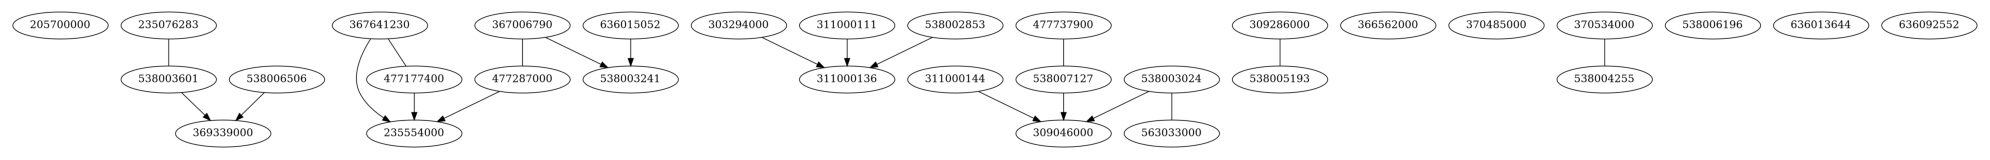

In [17]:
graph_la = pc(morning_tracks.values)
cols = list(morning_tracks.columns.values)
graph_la.draw_pydot_graph(labels=cols)

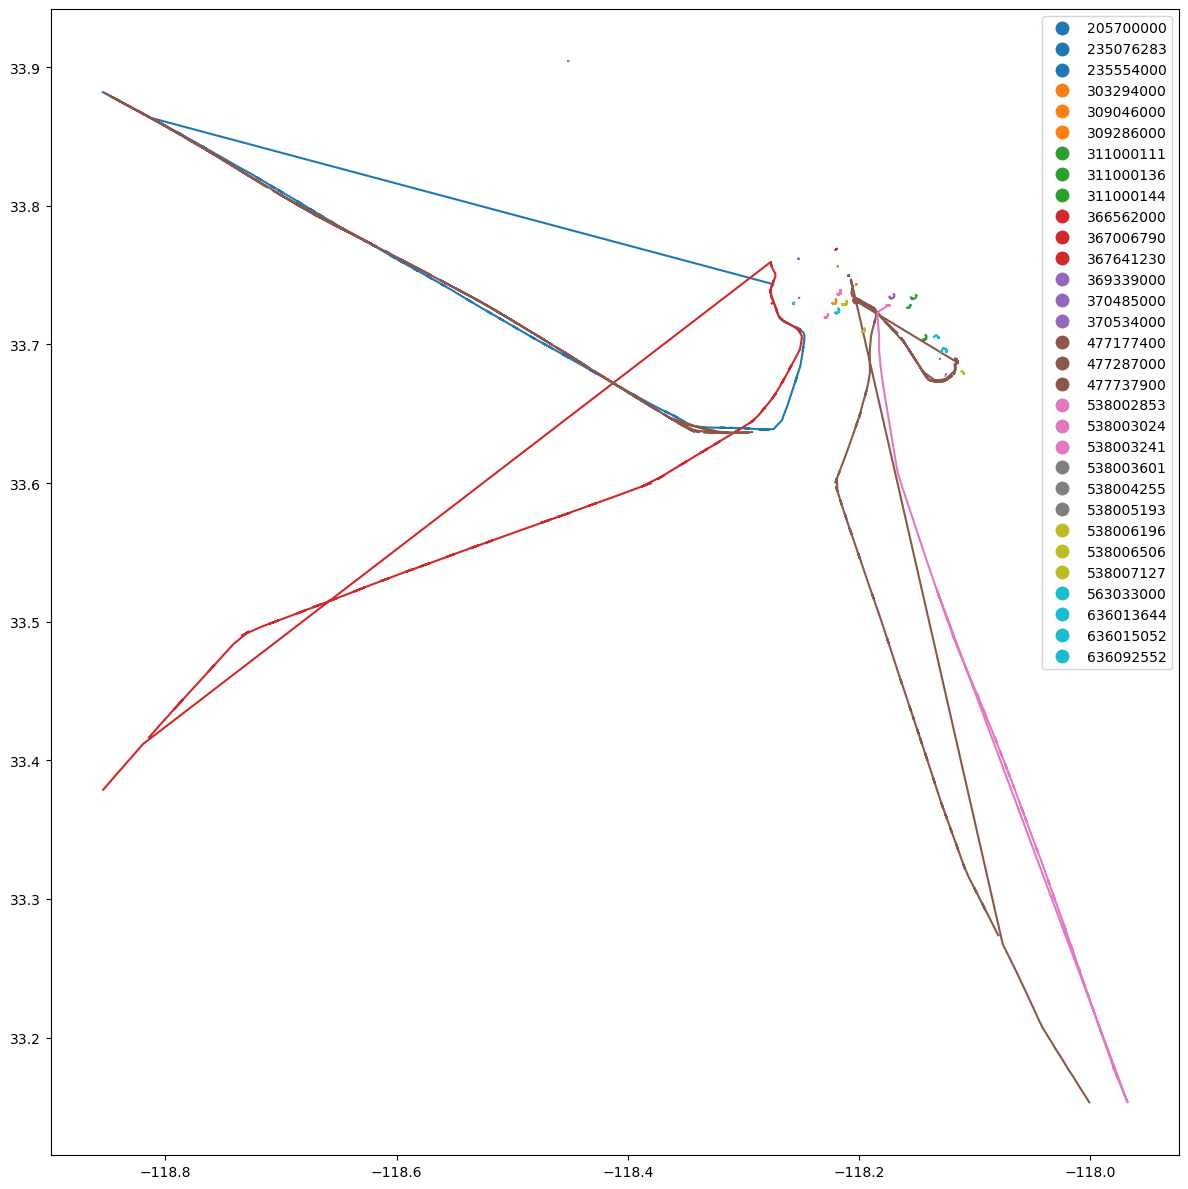

In [513]:
# Tracks for morning hours shown
morning_la_data = la_data[(la_data.BaseDateTime > start_time) & (la_data.BaseDateTime < end_time)]
morning_la_data = prepare_data_for_vis(morning_la_data)
all_ships = list(morning_tracks.columns.values)
draw_tracks(morning_la_data, all_ships)

**We can examine tracks from the graph using the below code**

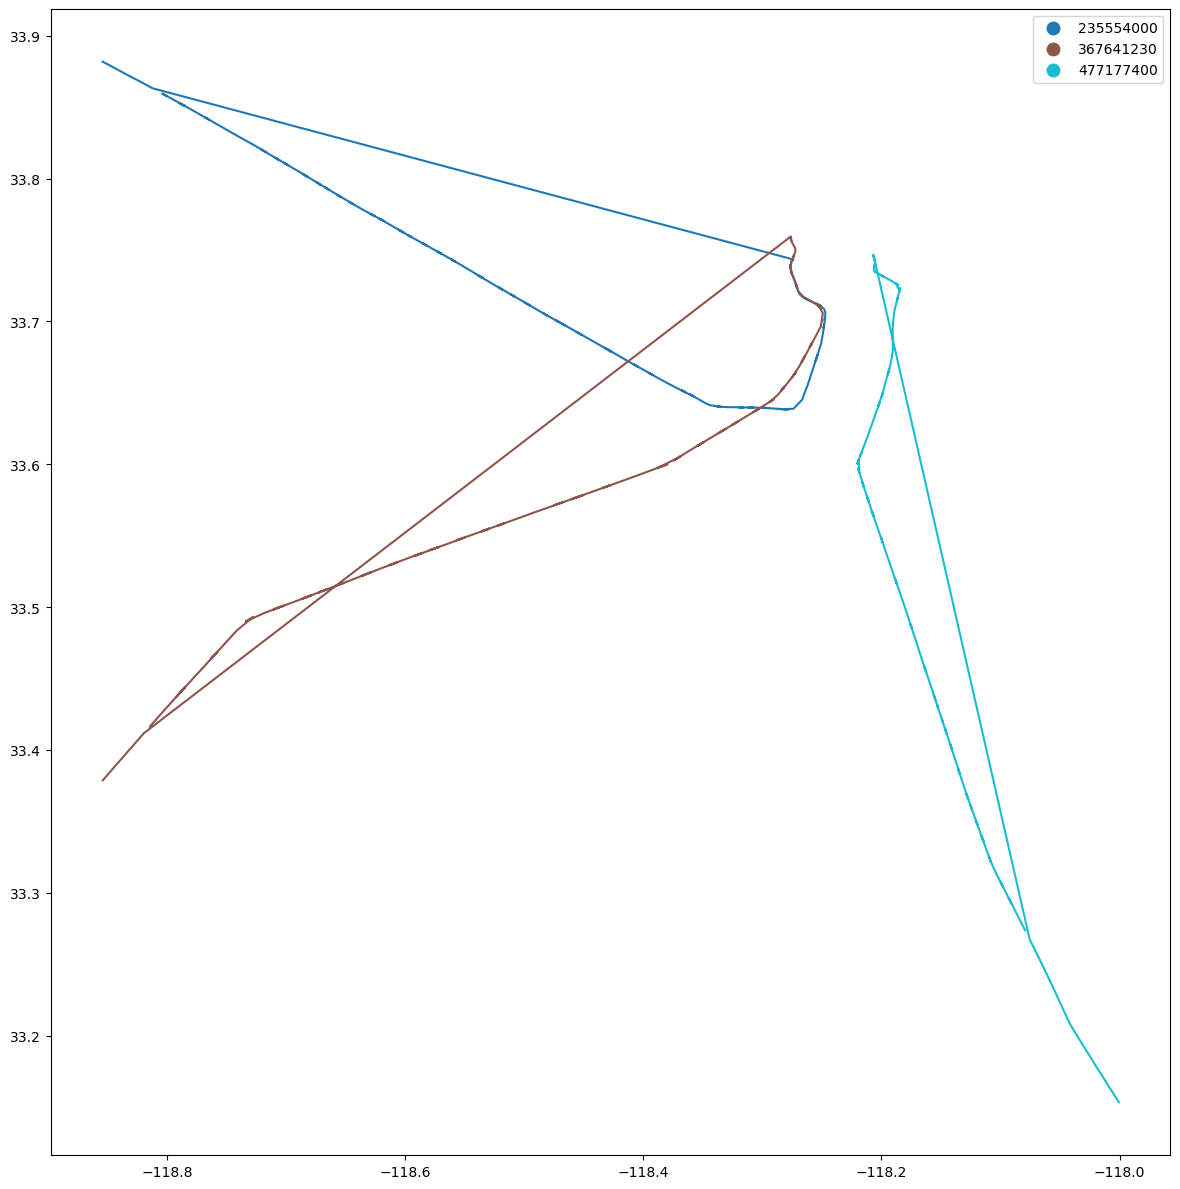

In [19]:
draw_tracks(morning_la_data, mmsi_list=[235554000, 477177400, 367641230])

## Timeshift Analysis Part I  
Here, we examine what the graphical structure looks like when we take one ship and duplicate the track. We then shift the duplicated track a certain amount of time and examine the effect on the graph representation.

In [20]:
# Data cleaning and processing functions
def clean_data_processor(data):
    clean_data = data.reset_index(drop=True)
    clean_data.drop(['LAT', 'LON', 'SOG', 'Heading'], axis=1, inplace=True)
    clean_data = clean_data.copy()
    clean_data = clean_data.set_index('BaseDateTime')
    clean_data = clean_data.sort_index()
    return clean_data

def get_tracks(data, time_interval="10T"):
    tracks_data = data.pivot_table(values='COG', index=data.index, columns='MMSI', aggfunc='first')
    tracks_data = tracks_data.fillna(0)
    tracks_data = tracks_data.resample(time_interval).mean()
    return tracks_data

def get_sub_tracks(tracks_data, start_time, end_time):
    mask = (tracks_data.index > start_time) & (tracks_data.index < end_time)
    sub_tracks_data = tracks_data[mask]
    # remove tracks with all constants
    nunique = sub_tracks_data.nunique()
    constant_cols = nunique[nunique == 1].index
    sub_tracks_data = sub_tracks_data.drop(constant_cols, axis=1)
    return sub_tracks_data

def time_shift_track(shift_delta, mmsi, new_mmsi, data):
    ship = data[data.MMSI == mmsi]
    time_shift_ship = ship.copy()
    time_shift_ship.MMSI = np.full(ship.shape[0], new_mmsi)
    time_shift_ship.BaseDateTime = time_shift_ship.BaseDateTime + pd.Timedelta(minutes=shift_delta)
    time_shift_ship.reset_index(drop=True, inplace=True)
    return pd.concat([time_shift_ship, data], ignore_index=True)

def get_pc_graph(tracks_data):
    graph_ocean = pc(tracks_data.values)
    cols = list(tracks_data.columns.values)
    graph_ocean.draw_pydot_graph(labels=cols)

**Sample 1**

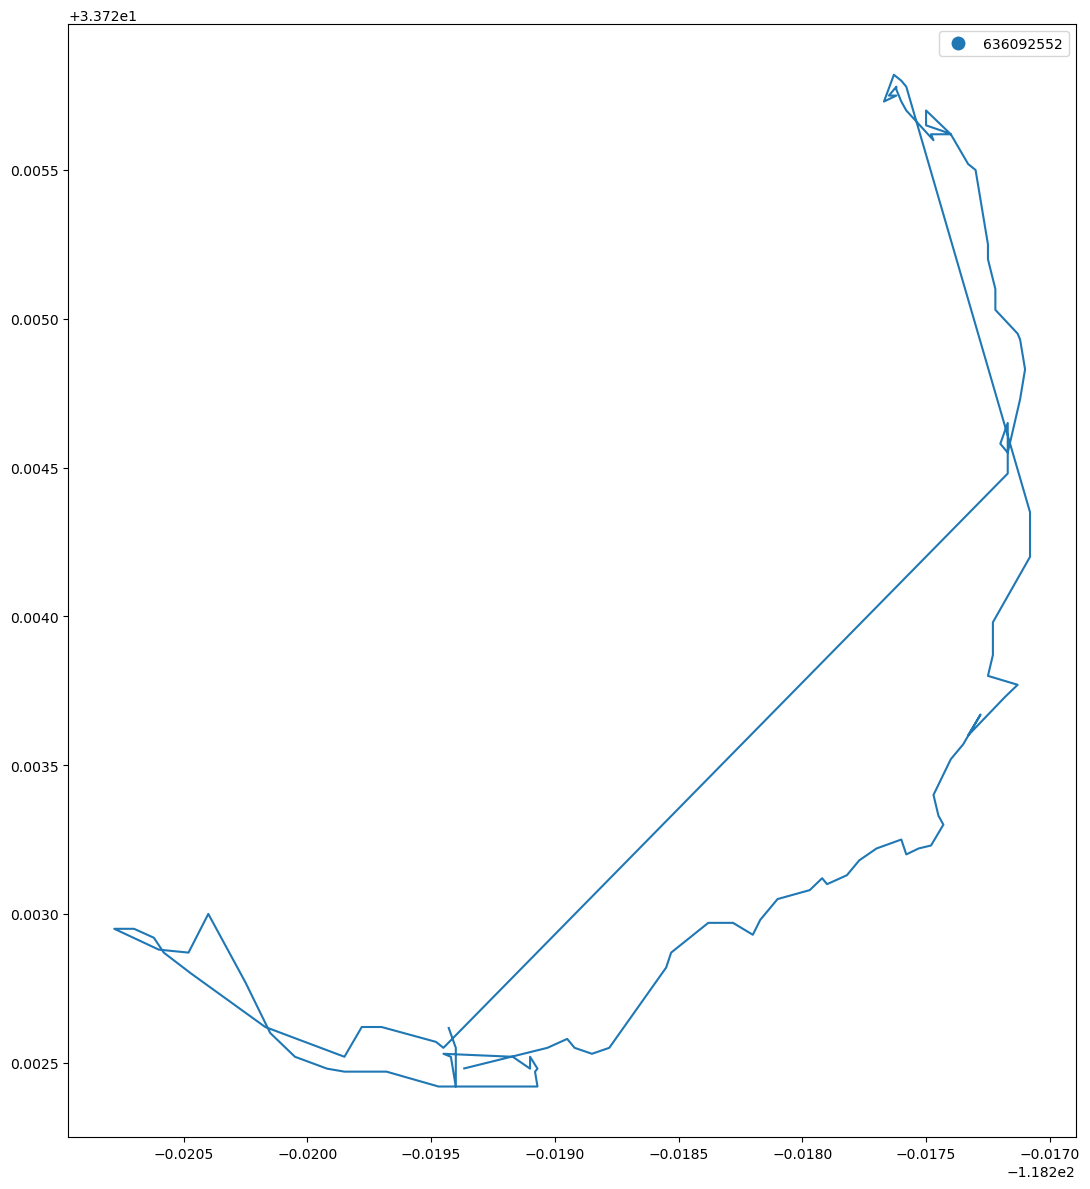

In [21]:
mmsi = 636092552
draw_tracks(morning_la_data, [mmsi])

  0%|          | 0/31 [00:00<?, ?it/s]

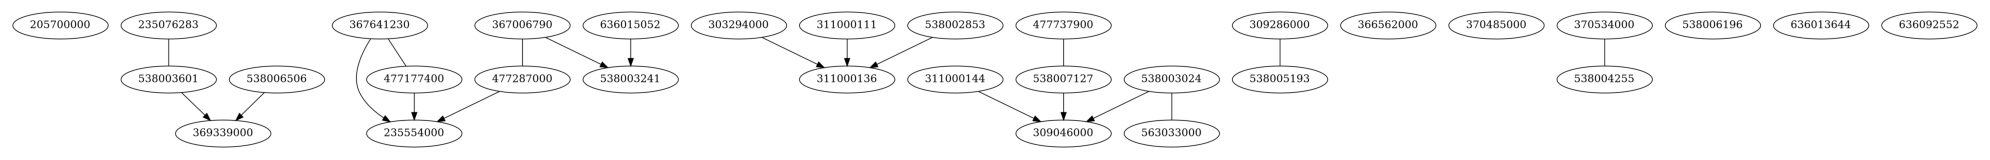

In [179]:
time_shift_la_data = time_shift_track(5, mmsi, 1, morning_la_data)
time_shift_la_data = time_shift_track(10, mmsi, 2, time_shift_la_data)
time_shift_la_data = time_shift_track(30, mmsi, 3, time_shift_la_data)
time_shift_la_data = time_shift_track(60, mmsi, 4, time_shift_la_data)
time_shift_la_data = time_shift_track(120, mmsi, 5, time_shift_la_data)

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data, time_interval="10T")
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

Above, we see that only the 5 and 10 minute track are connected to the original track. This might make sense as the track appears stochastic, thus the replicated tracks may not be correlated with the original.

**Sample 2**  
Here, we examine a track that does not appear stochastic. There seems to be a route the ship is taking. 

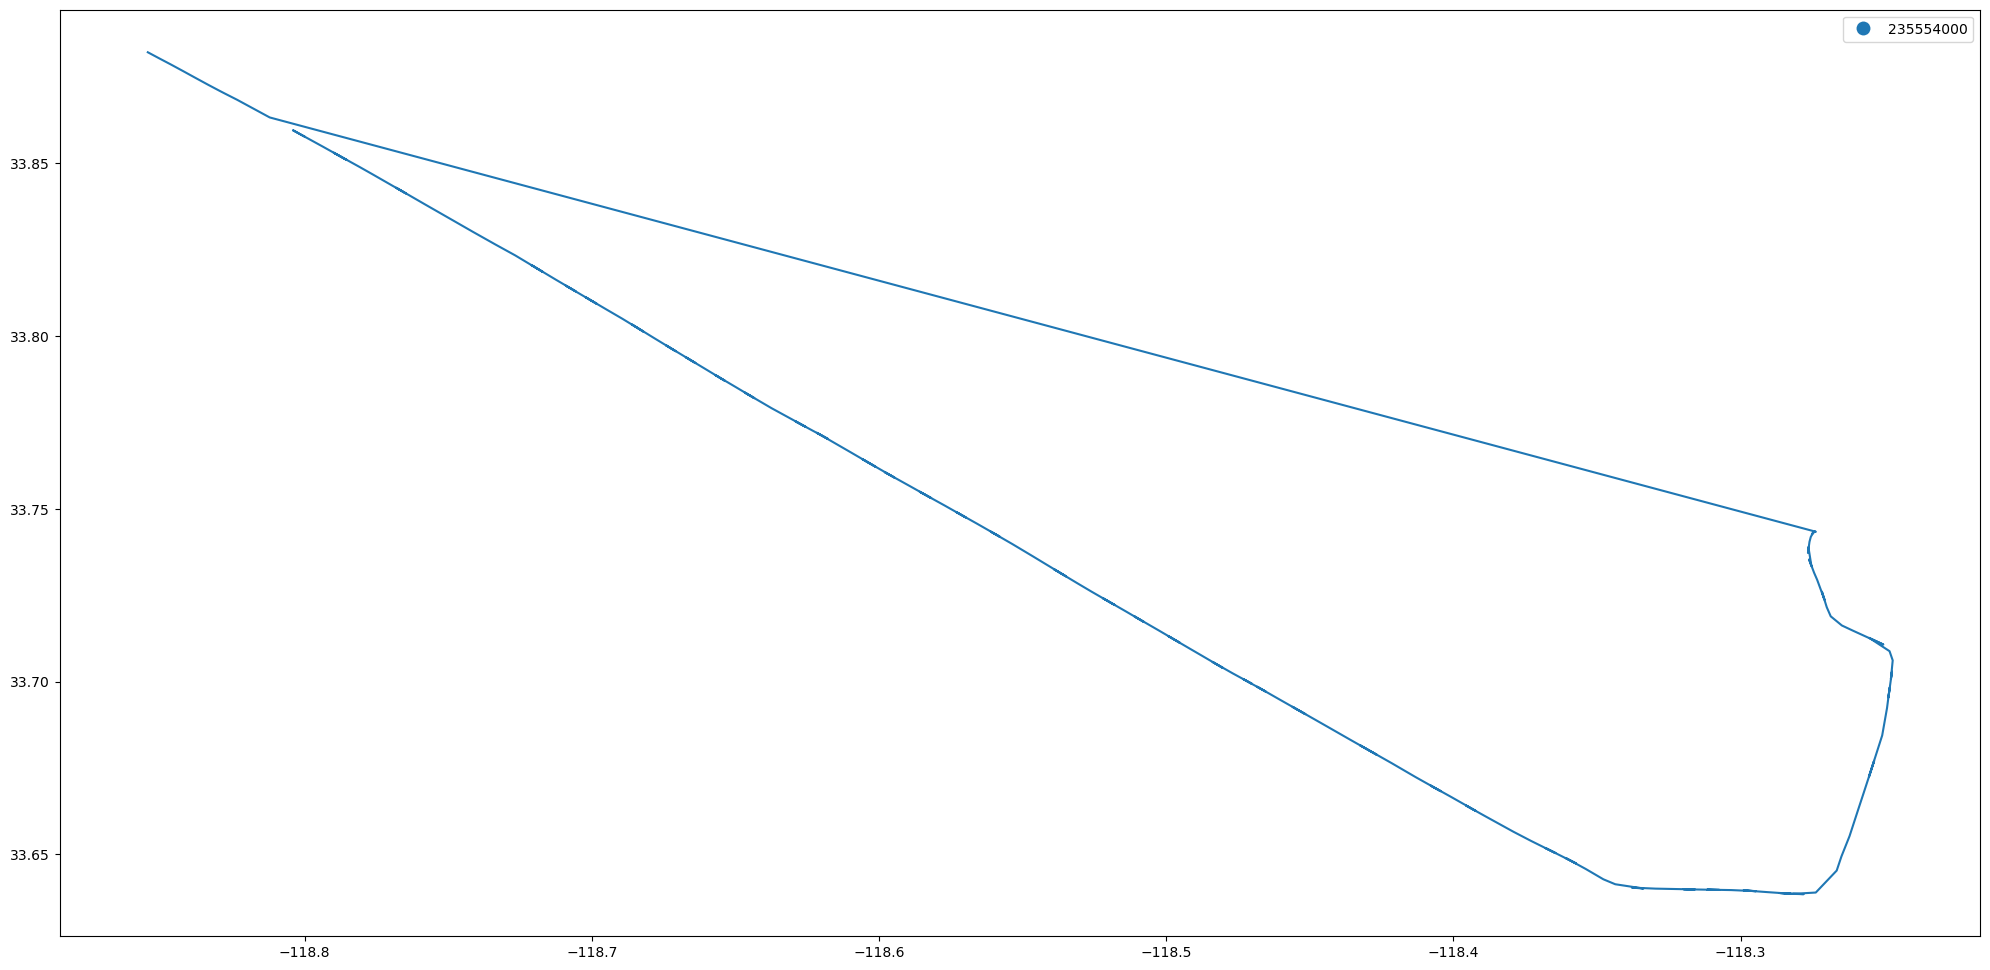

In [23]:
mmsi = 235554000
draw_tracks(morning_la_data, [mmsi])

  0%|          | 0/36 [00:00<?, ?it/s]

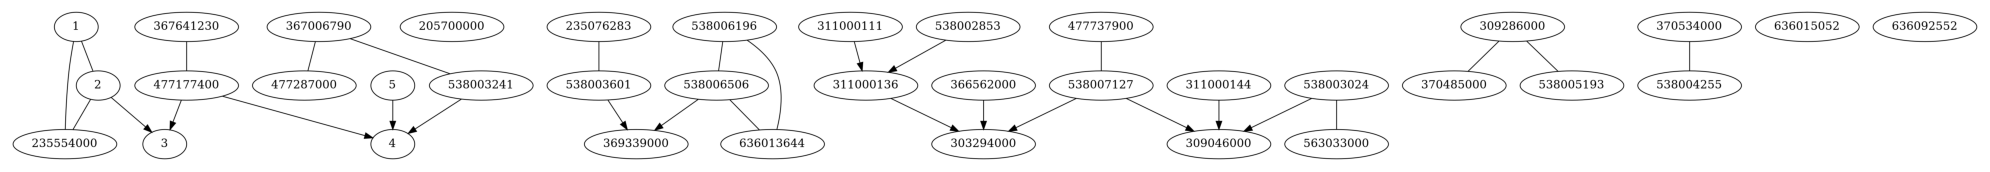

In [24]:
time_shift_la_data = time_shift_track(5, mmsi, 1, morning_la_data)
time_shift_la_data = time_shift_track(10, mmsi, 2, time_shift_la_data)
time_shift_la_data = time_shift_track(30, mmsi, 3, time_shift_la_data)
time_shift_la_data = time_shift_track(60, mmsi, 4, time_shift_la_data)
time_shift_la_data = time_shift_track(120, mmsi, 5, time_shift_la_data)

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

We see more connections between the original track and the replicated tracks. This makes sense since the original track does not appear stochastic, we would expect timeshifted tracks to remain correlated with eachother. 

## Timeshift Analysis Part II  
In this section we consider how far apart a track needs to be timewise in order for the graph to appear disconnected. We will examine a track that does not appear stochastic as we would expect this track to be strongly correlated with small timeshifted duplicates. 

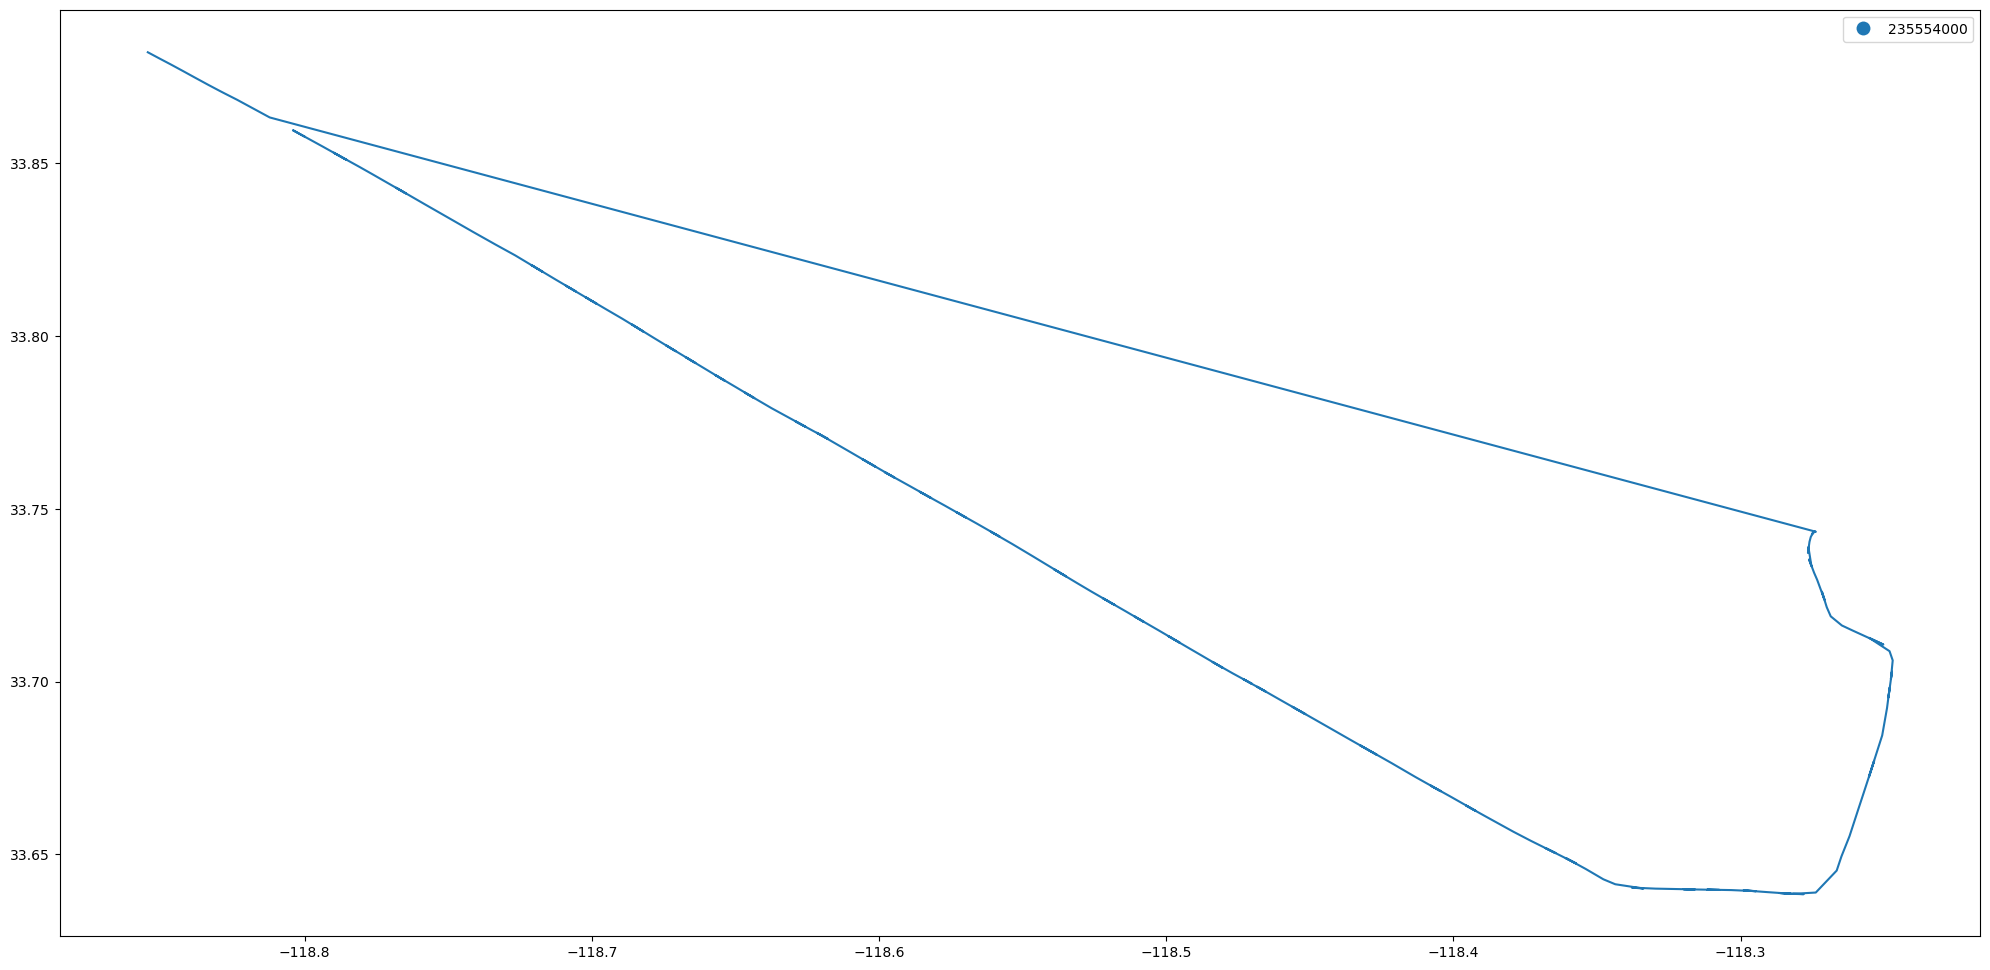

In [25]:
mmsi = 235554000
draw_tracks(morning_la_data, [mmsi])

  0%|          | 0/32 [00:00<?, ?it/s]

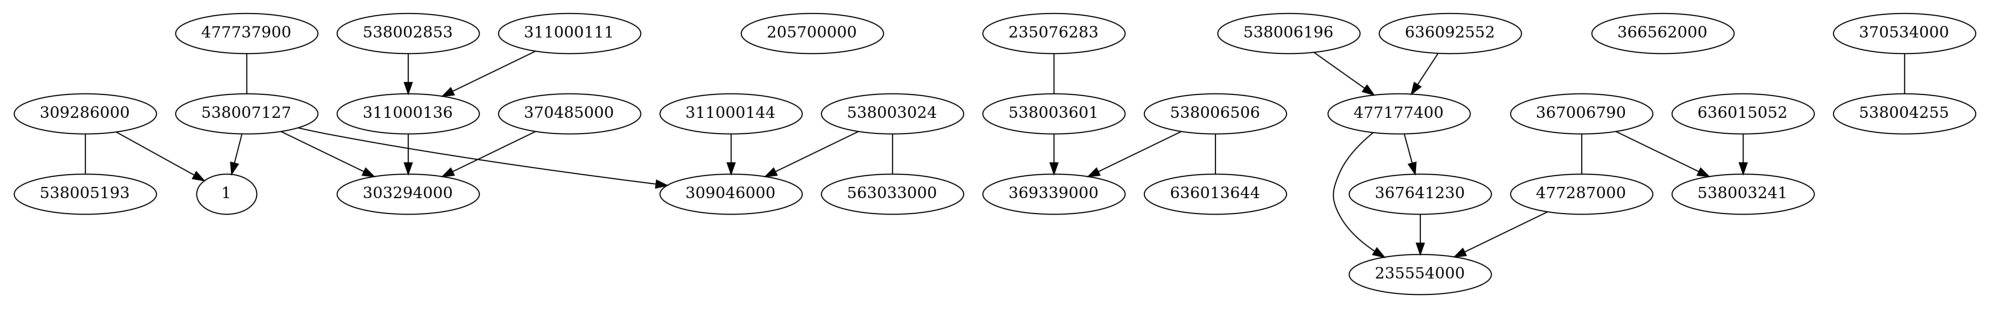

In [26]:
# Looking at 3 hours of time shift
time_shift_la_data = time_shift_track(180, mmsi, 1, morning_la_data)

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

3 hours of timeshift results in no connection in the graph.

  0%|          | 0/32 [00:00<?, ?it/s]

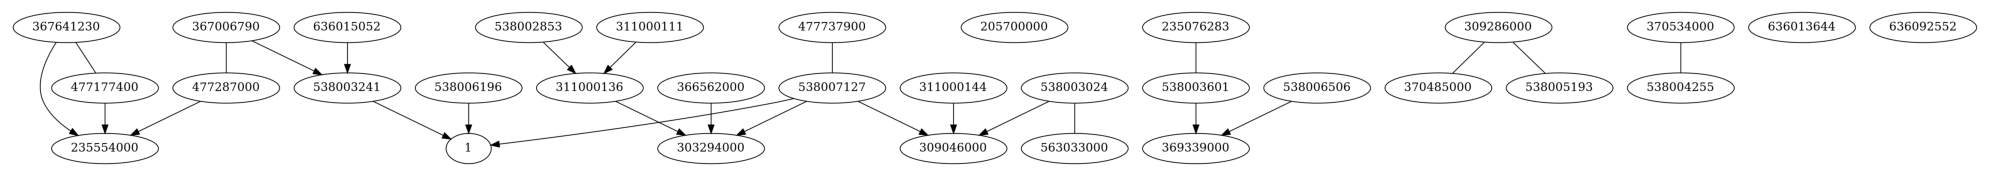

In [27]:
# Looking at 2 hours of time shift
time_shift_la_data = time_shift_track(120, mmsi, 1, morning_la_data)

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

2 hours results in no connection in the graph.

  0%|          | 0/32 [00:00<?, ?it/s]

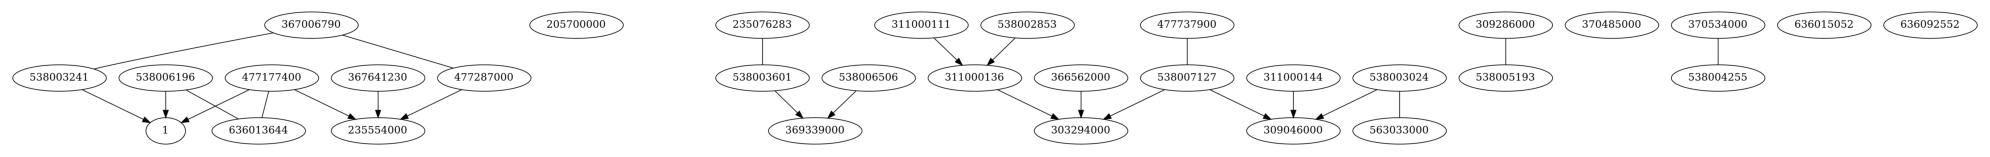

In [28]:
# Looking at 1 hour of time shift
time_shift_la_data = time_shift_track(60, mmsi, 1, morning_la_data)

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

1 hour of timeshift results in a connection of distance 2 in the graph.

  0%|          | 0/32 [00:00<?, ?it/s]

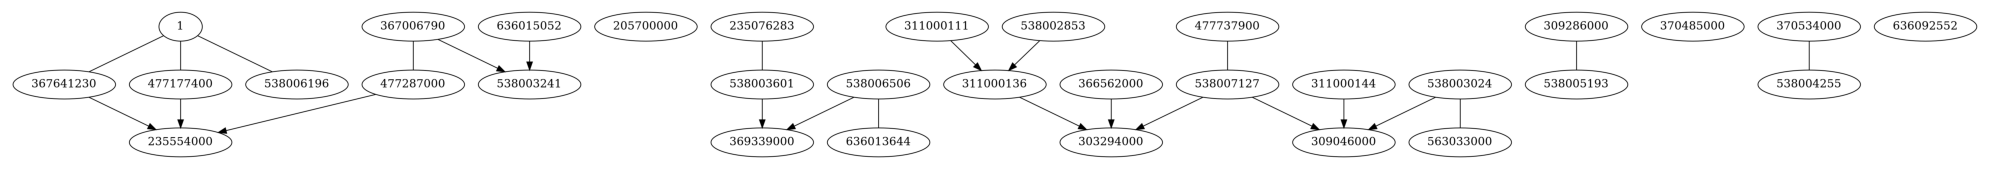

In [29]:
# Looking at 1/2 hour of time shift
time_shift_la_data = time_shift_track(30, mmsi, 1, morning_la_data)

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

1/2 hour of timeshift results in a connection of distance 2 in the graph.

  0%|          | 0/32 [00:00<?, ?it/s]

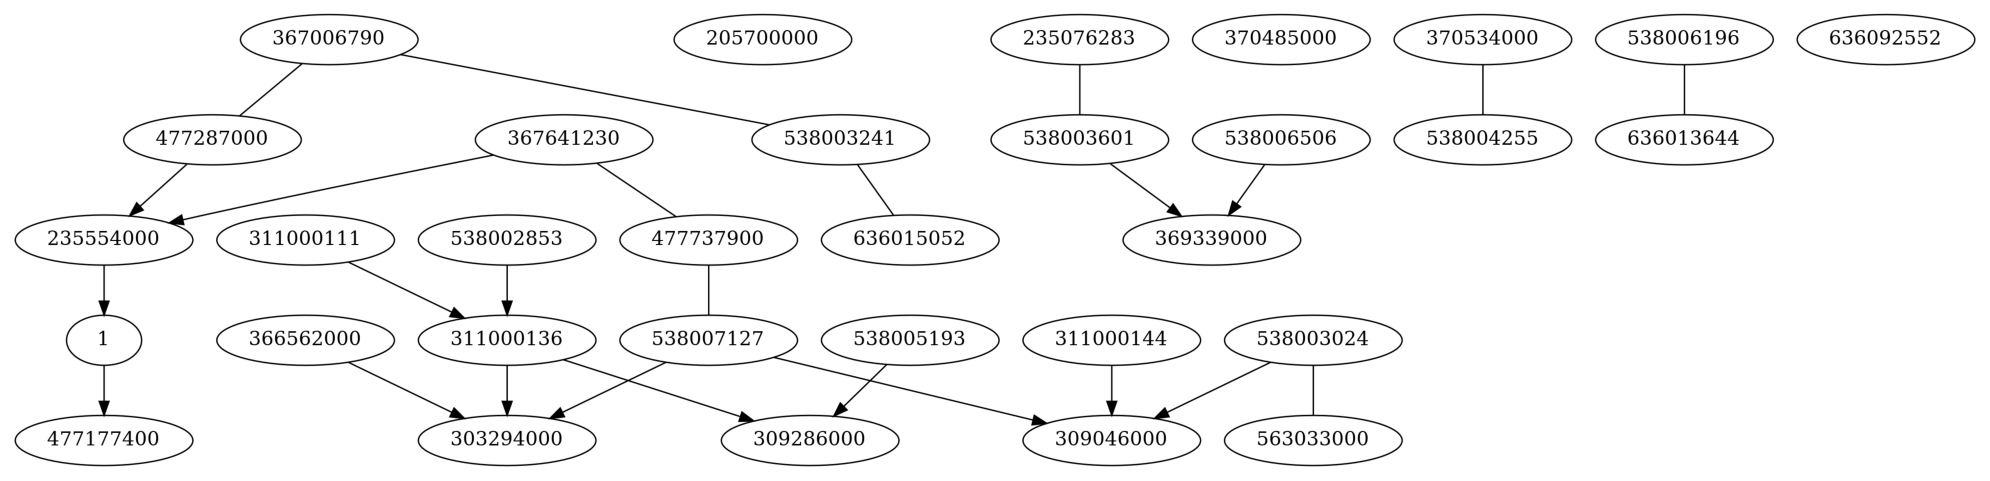

In [30]:
# Looking at 15 minutes of time shift
time_shift_la_data = time_shift_track(15, mmsi, 1, morning_la_data)

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)
morning_tracks = get_sub_tracks(tracks_data, start_time, end_time)

get_pc_graph(morning_tracks)

15 minutes of timeshift results in a direction connection between the original and duplicated track in the graph.

## Timeshift Analysis Part III  
Now we will look at two separate tracks that appear to have a very similar route. We will change the timestamps of one graph to match the other graph identically. This should result in a strong correlation between the two similar tracks. We will then repeat the above two analyses to see how duplicating the tracks and change the timeshifts affect the graph representation. 

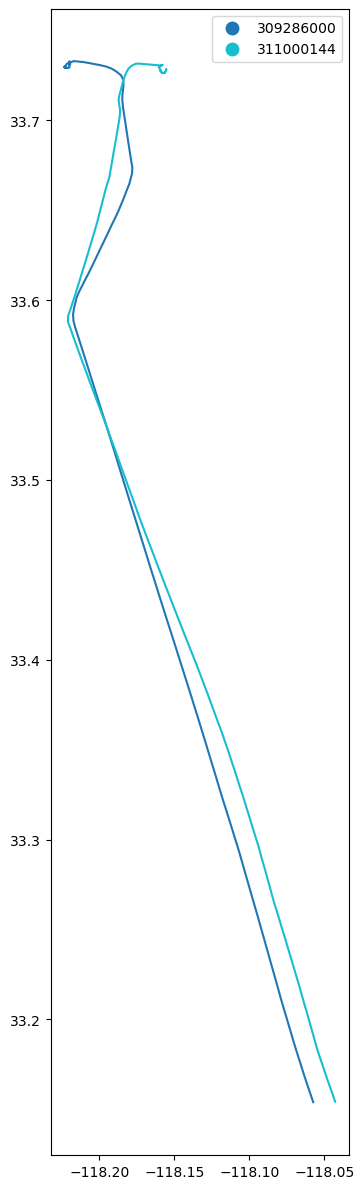

In [31]:
similar = [309286000, 311000144]
draw_tracks(la_data, similar)

In [32]:
mmsi_1 = similar[0]
mmsi_2 = similar[1]
data = la_data

In [33]:
ship_1 = data[data.MMSI == mmsi_1]
ship_2 = data[data.MMSI == mmsi_2]
ship_2 = ship_2.sample(ship_1.shape[0]).sort_index()
ship_2.BaseDateTime = ship_1.BaseDateTime.tolist()

In [34]:
data = pd.concat([data[data.MMSI != mmsi_2], ship_2])
data.sort_values(by="BaseDateTime", inplace=True)

Drawing the graph representation should display a direct connection between these two tracks.

  0%|          | 0/57 [00:00<?, ?it/s]

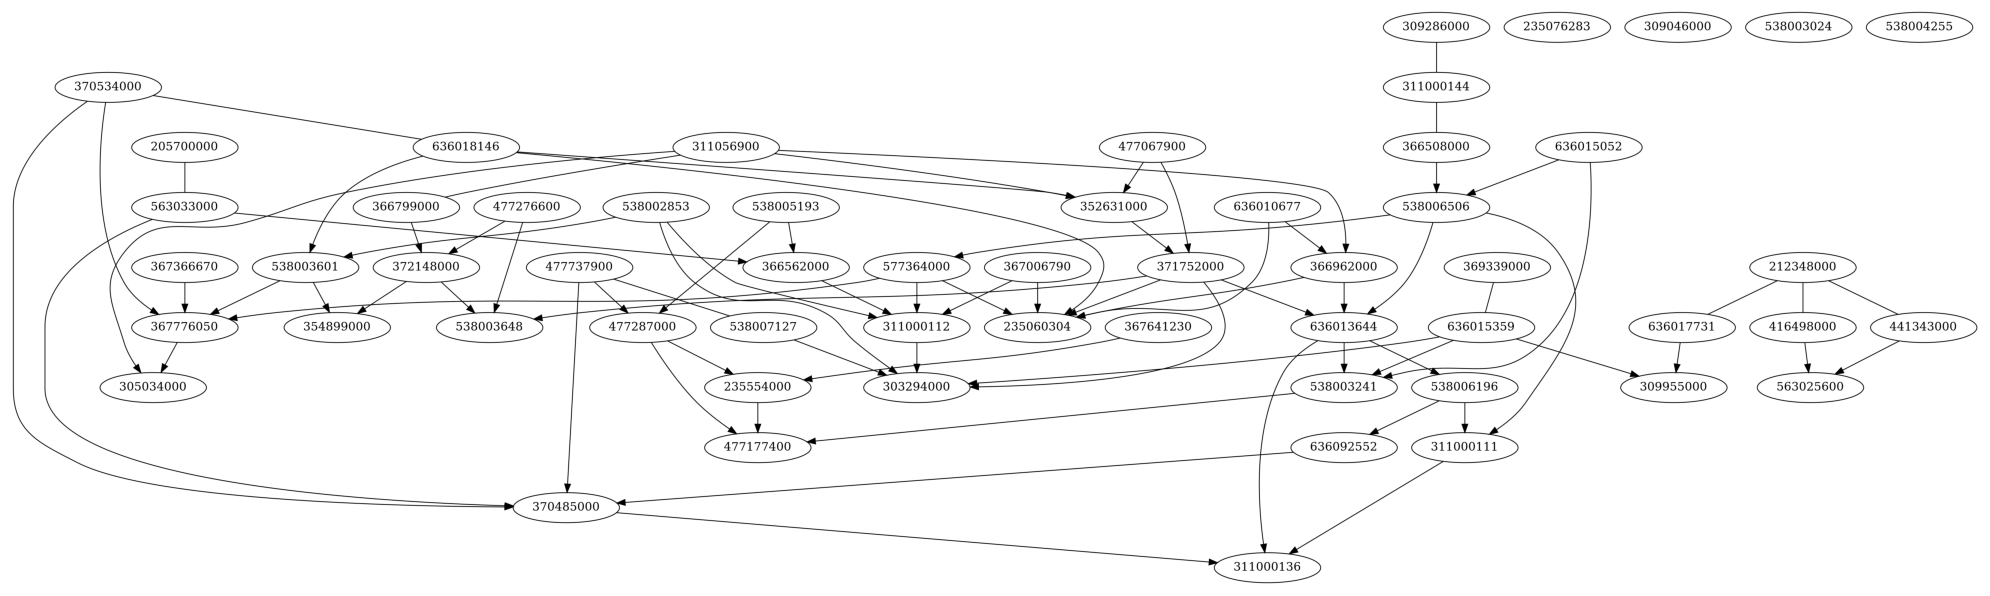

In [35]:
clean_data = clean_data_processor(data)
tracks_ts_3 = get_tracks(clean_data)

get_pc_graph(tracks_ts_3)

  0%|          | 0/57 [00:00<?, ?it/s]

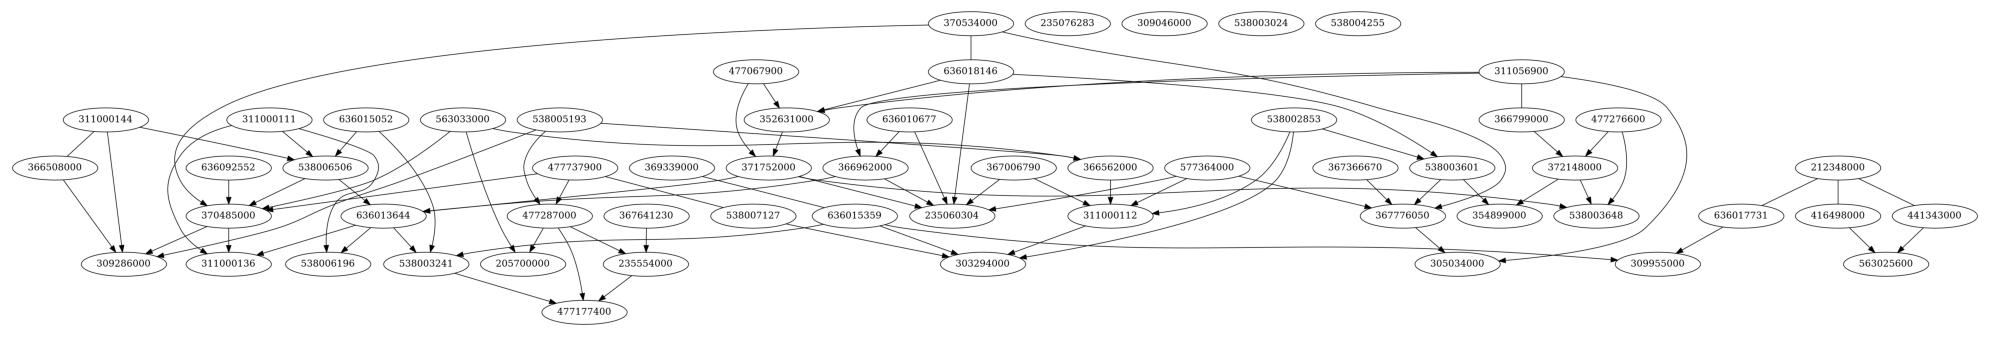

In [36]:
graph = pc(tracks.values)
cols = list(tracks.columns.values)
graph.draw_pydot_graph(labels=cols)

From the above graphs we see that the tracks were already directly connected in the original data as well as the altered data. What if we time shift the altered data so that one track gets further apart timewise?

  0%|          | 0/57 [00:00<?, ?it/s]

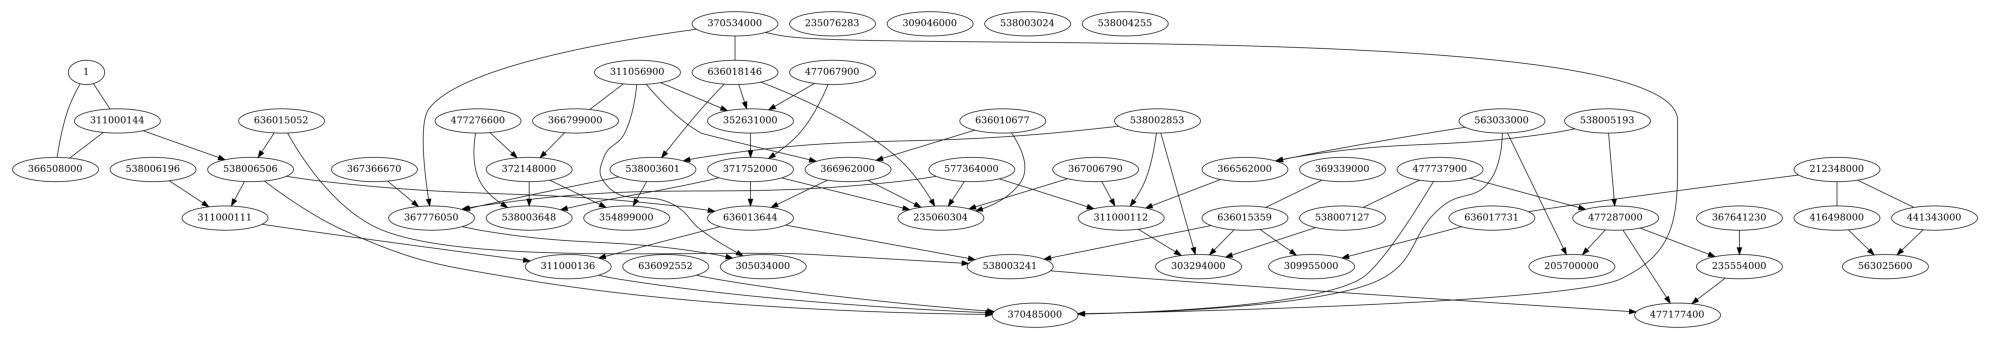

In [37]:
# Timeshift the first track 15 minutes
mmsi = similar[0]
time_shift_la_data = time_shift_track(15, mmsi, 1, la_data)

# Remove the first track so that only the timeshifted one is included
time_shift_la_data = time_shift_la_data[time_shift_la_data.MMSI != similar[0]]

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)

get_pc_graph(tracks_data)

With 15 minutes of timeshift, the two tracks are still directly connected.

  0%|          | 0/57 [00:00<?, ?it/s]

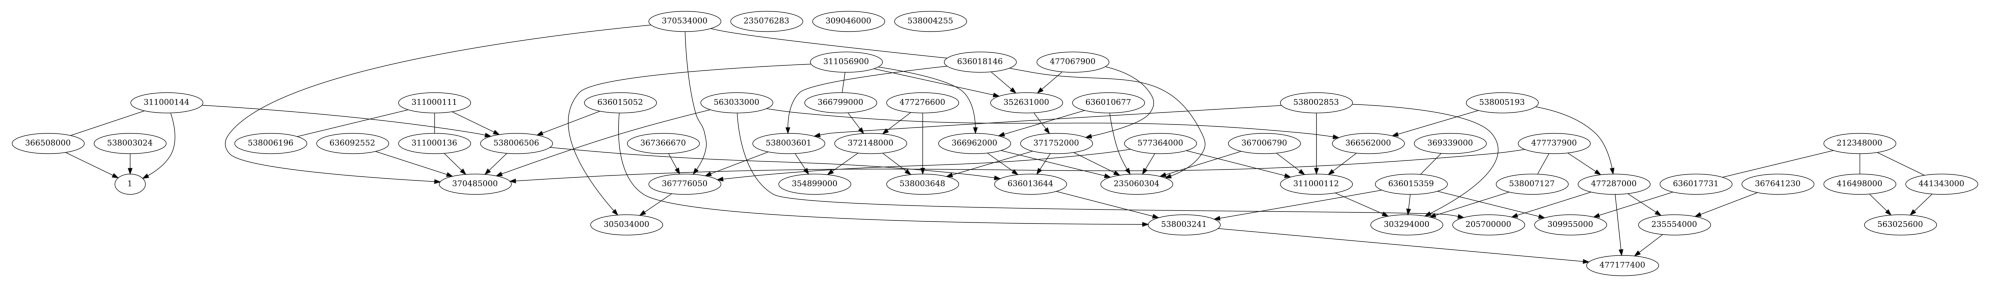

In [38]:
# Timeshift the first track 30 minutes
mmsi = similar[0]
time_shift_la_data = time_shift_track(30, mmsi, 1, la_data)

# Remove the first track so that only the timeshifted one is included
time_shift_la_data = time_shift_la_data[time_shift_la_data.MMSI != similar[0]]

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)

get_pc_graph(tracks_data)

With 30 minutes of timeshift the two tracks are directly connected.

  0%|          | 0/57 [00:00<?, ?it/s]

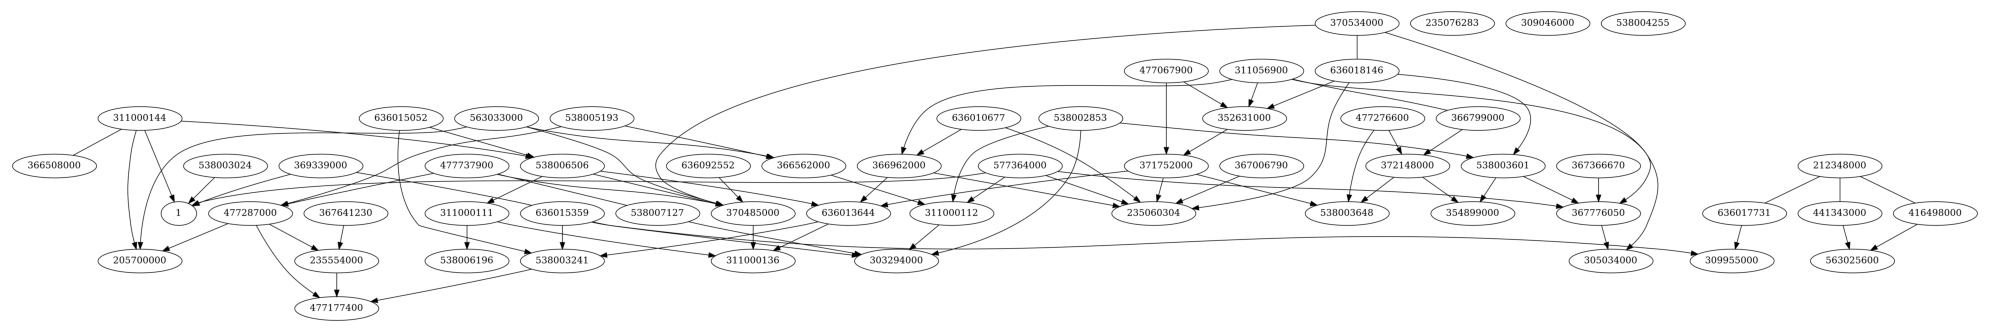

In [39]:
# Timeshift the first track 60 minutes
mmsi = similar[0]
time_shift_la_data = time_shift_track(60, mmsi, 1, la_data)

# Remove the first track so that only the timeshifted one is included
time_shift_la_data = time_shift_la_data[time_shift_la_data.MMSI != similar[0]]

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)

get_pc_graph(tracks_data)

With 60 minutes of timeshift the two tracks are still directly connected.

  0%|          | 0/57 [00:00<?, ?it/s]

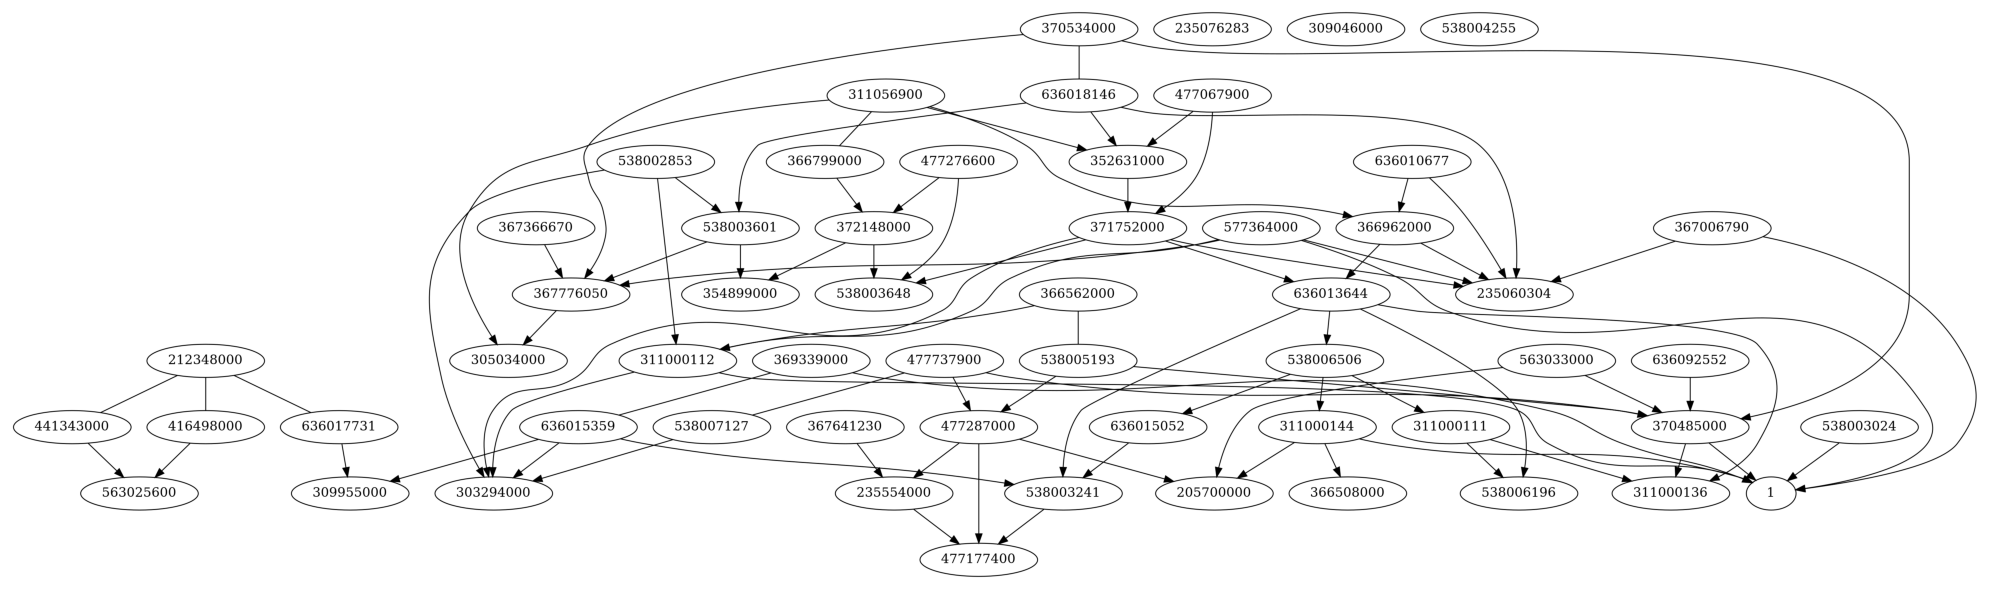

In [40]:
# Timeshift the first track 2 hours
mmsi = similar[0]
time_shift_la_data = time_shift_track(120, mmsi, 1, la_data)

# Remove the first track so that only the timeshifted one is included
time_shift_la_data = time_shift_la_data[time_shift_la_data.MMSI != similar[0]]

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)

get_pc_graph(tracks_data)

With 2 hours of timeshift the two tracks are still directly connected. 

  0%|          | 0/57 [00:00<?, ?it/s]

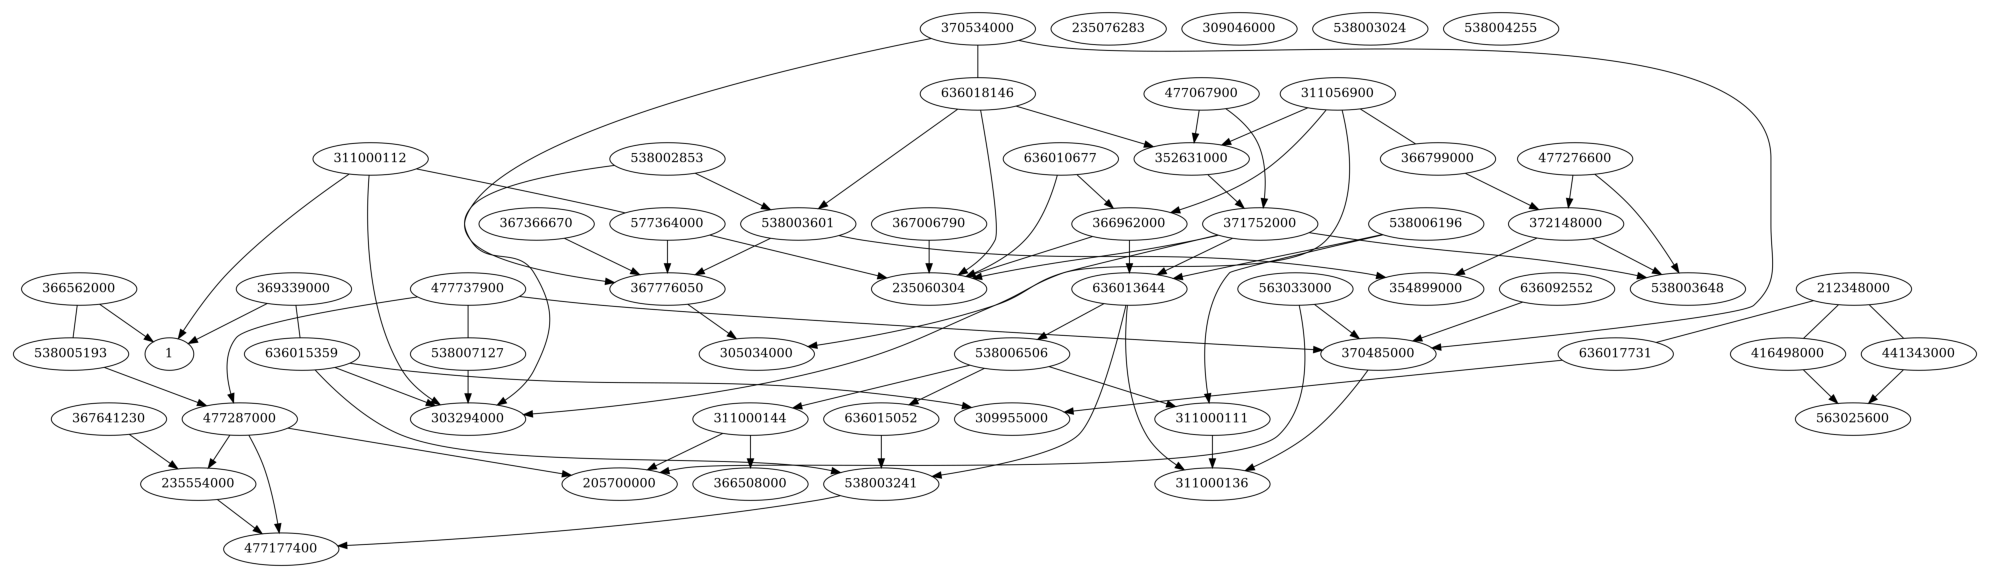

In [41]:
# Timeshift the first track 5 hours
mmsi = similar[0]
time_shift_la_data = time_shift_track(180, mmsi, 1, la_data)

# Remove the first track so that only the timeshifted one is included
time_shift_la_data = time_shift_la_data[time_shift_la_data.MMSI != similar[0]]

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)

get_pc_graph(tracks_data)

The two tracks are no longer connected after 3 hours of timeshift. This is a much larger amount of time needed to disconnect the two nodes than the previous analysis. However, the previous analysis only used data from the morning hours, whereas this analysis used a full day of track data. It follows that with more track data available to build the graph, a larger difference would be needed to separate the tracks. 

**Sub Analysis**  
We want to see if we duplicate the two similar tracks with a timeshift between each duplication, will we see a chain representation in the graph?

  0%|          | 0/60 [00:00<?, ?it/s]

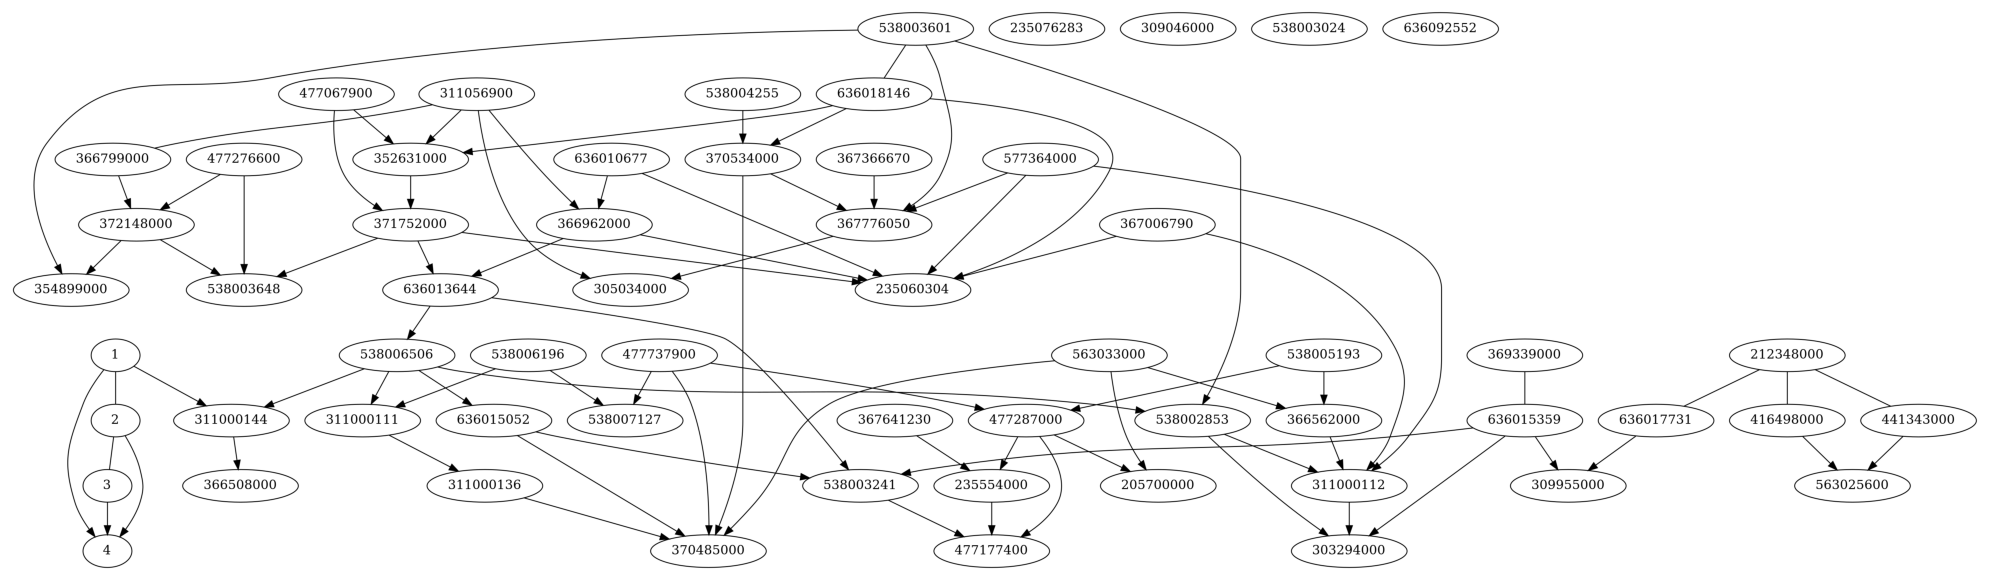

In [42]:
mmsi = similar[0]
time_shift_la_data = time_shift_track(5, mmsi, 1, la_data)
time_shift_la_data = time_shift_track(10, mmsi, 2, time_shift_la_data)
time_shift_la_data = time_shift_track(15, mmsi, 3, time_shift_la_data)
time_shift_la_data = time_shift_track(20, mmsi, 4, time_shift_la_data)

# Remove the first track so that only the timeshifted one is included
time_shift_la_data = time_shift_la_data[time_shift_la_data.MMSI != similar[0]]

clean_data = clean_data_processor(time_shift_la_data)
tracks_data = get_tracks(clean_data)

get_pc_graph(tracks_data)

Sure enough, we see a chain structure as we would expect. This means that ships following a similar course close together in time have a chain like structure.

## Analysis Plan  
From the graph analysis above, we have learned that two tracks which are identical, or very similar, only appear directly connected on the graph when they are within a certain time range of eachother. That is, two very similar tracks that are an hour apart are much less likely to be connected but are much more likely when 15 minutes apart. Working off of this knowledge, can we devise a more systematic approach to know what is the ideal amount of time shift to connect two nodes? Here is the plan of action:  
1. Generate a group of two random tracks from the data
2. Take one of the tracks and copy it to a timeshifted track in increments of 5 from -60 minutes to +60
3. For each of these new tracks, pair it with the original, uncopied track and calculate the correlation of the two tracks at that timeshift delta
4. Store the correlation and the timeshift it is associated with
5. Repeat this process with 500 random track groups
6. Plot the distribution of correlations across the timeshift deltas

Bonus: Once you find the timeshift delta that maximizes the correlation, calculate the correlations between all pairs of ships. Using a threshold for correlation, we will say there exists an edge between two tracks if they are correlated over that threshold. Now construct a graph given all the edges and nodes.

**Does it make sense that when we shift the timestamps by delta that the values should be different between the original and the new track? I believe this makes sense. What is happening is that when you move a timestamp, mainly the last one, by, for instance, 10 minutes, this record may be in an area of much less density, i.e. there are no other records near this timestamp. This means when you take the average across 10 minutes, there are no other timestamps except the timeshifted one, resulting in a different value than the original timestamp. Should we continue doing it this way? Maybe we want to take the average COG across the next few records of each individual track and ignore no records?**

In [444]:
# Step 1
sample = tracks.sample(axis='columns', n=2)
mmsi_list = list(sample.columns.values)

In [445]:
# Step 2
correlation_map = {}
for i in range(-60, 65, 5):
    correlation_map[i] = []

In [446]:
# Step 2 continued

correlation_map = {}
for i in range(-60, 65, 10):
    correlation_map[i] = []
    
for _ in range(50):
    for i in correlation_map.keys():
        sample = tracks.sample(axis='columns', n=2)
        mmsi_list = list(sample.columns.values)
        mmsi_original = mmsi_list[0]
        mmsi_shifted = 1
        mmsi_pair = mmsi_list[1]
        
        time_shift_la_data = time_shift_track(i, mmsi_original, mmsi_shifted, la_data) # timeshift the track
        clean_data = clean_data_processor(time_shift_la_data)
        tracks_data = get_tracks(clean_data, time_interval="10T")
        tracks_data = tracks_data.fillna(0)
        # Find correlation between pair track and shifted track
        corr = np.corrcoef(tracks_data[mmsi_shifted].values, tracks_data[mmsi_pair].values)[0][1] 
        correlation_map[i].append(corr)

Text(0, 0.5, 'y-axis')

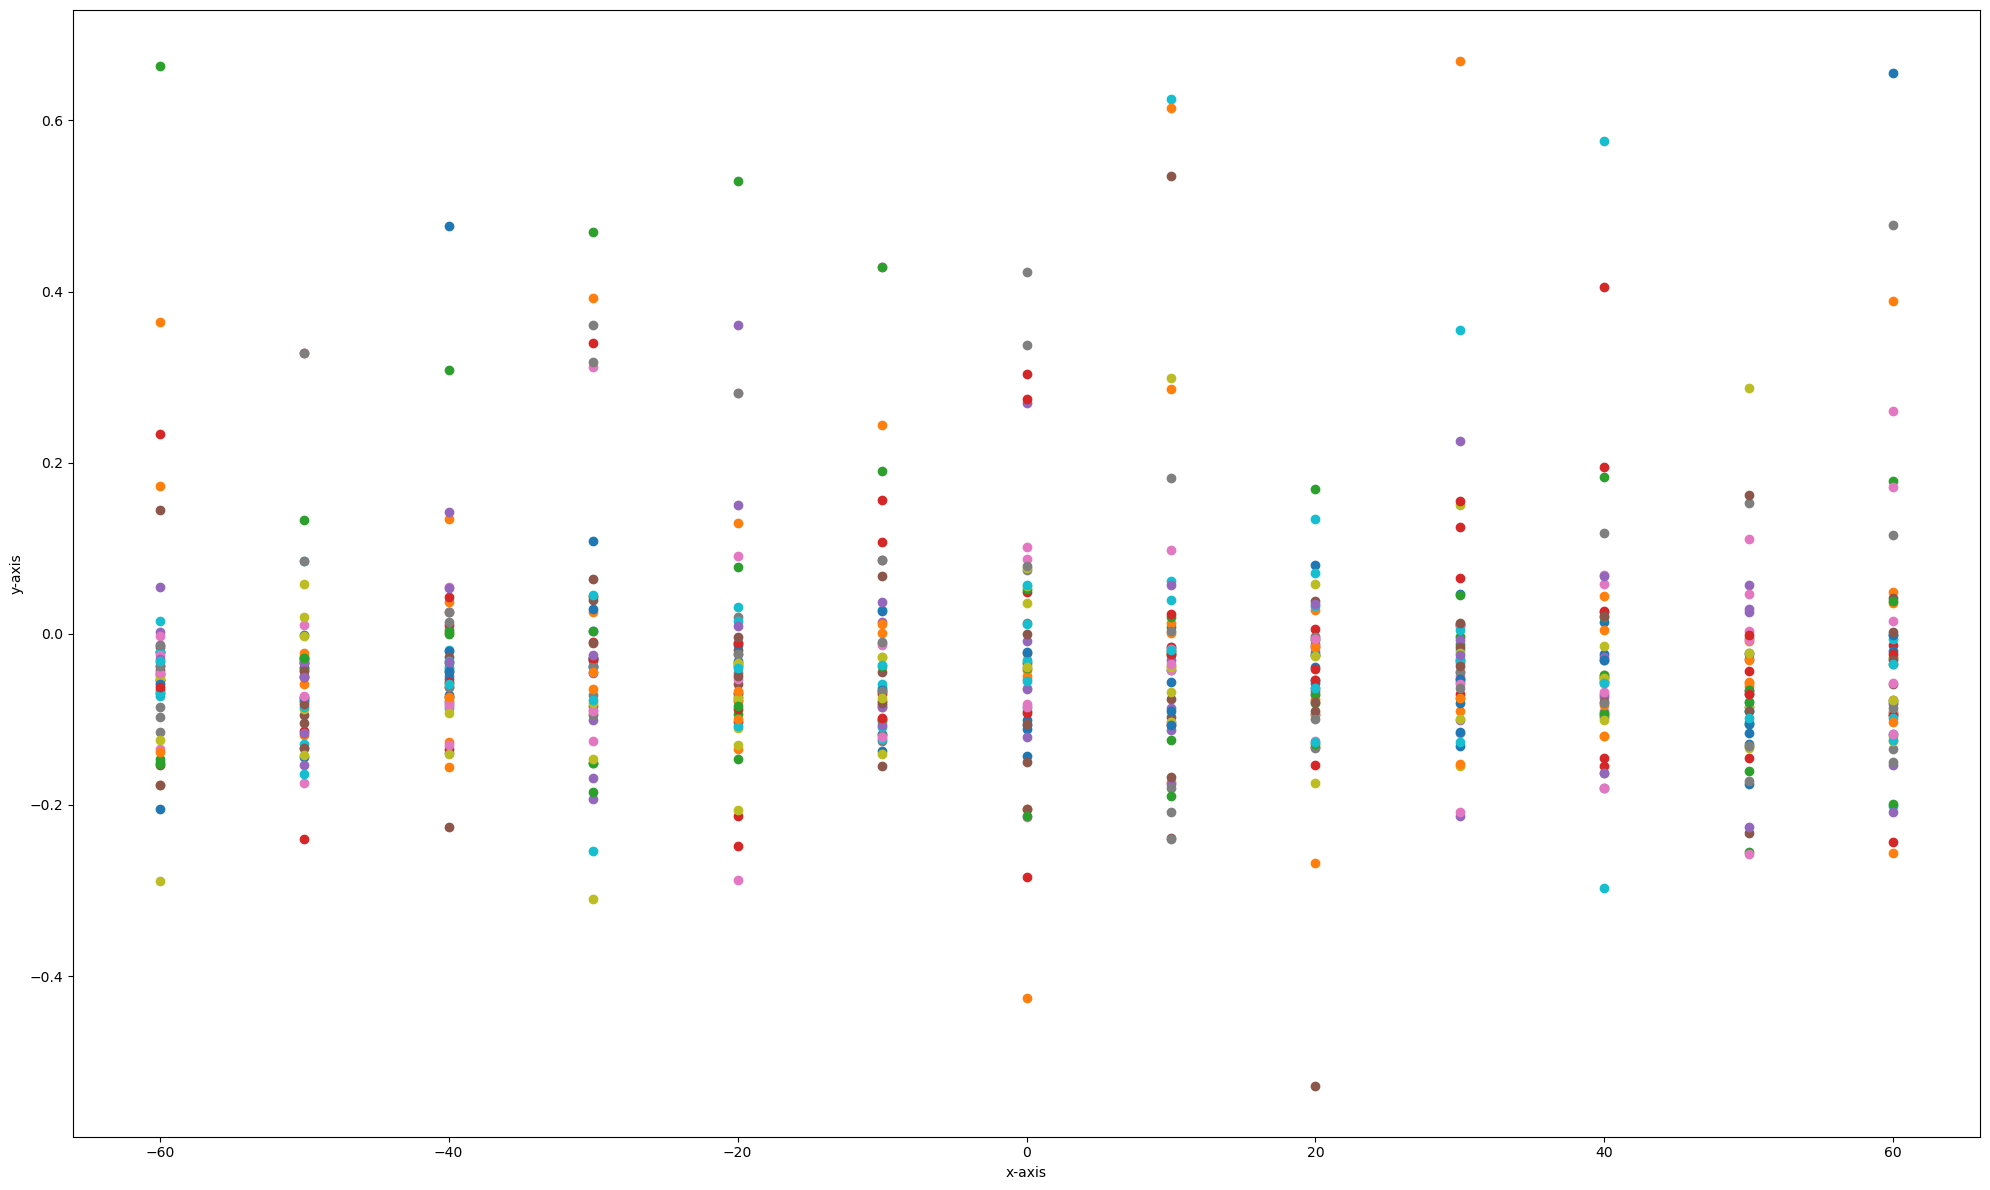

In [447]:
fig, ax = plt.subplots()
for key, value in correlation_map.items():
    for corr in value:
        ax.scatter(key,corr)
plt.xlabel('x-axis')
plt.ylabel('y-axis')


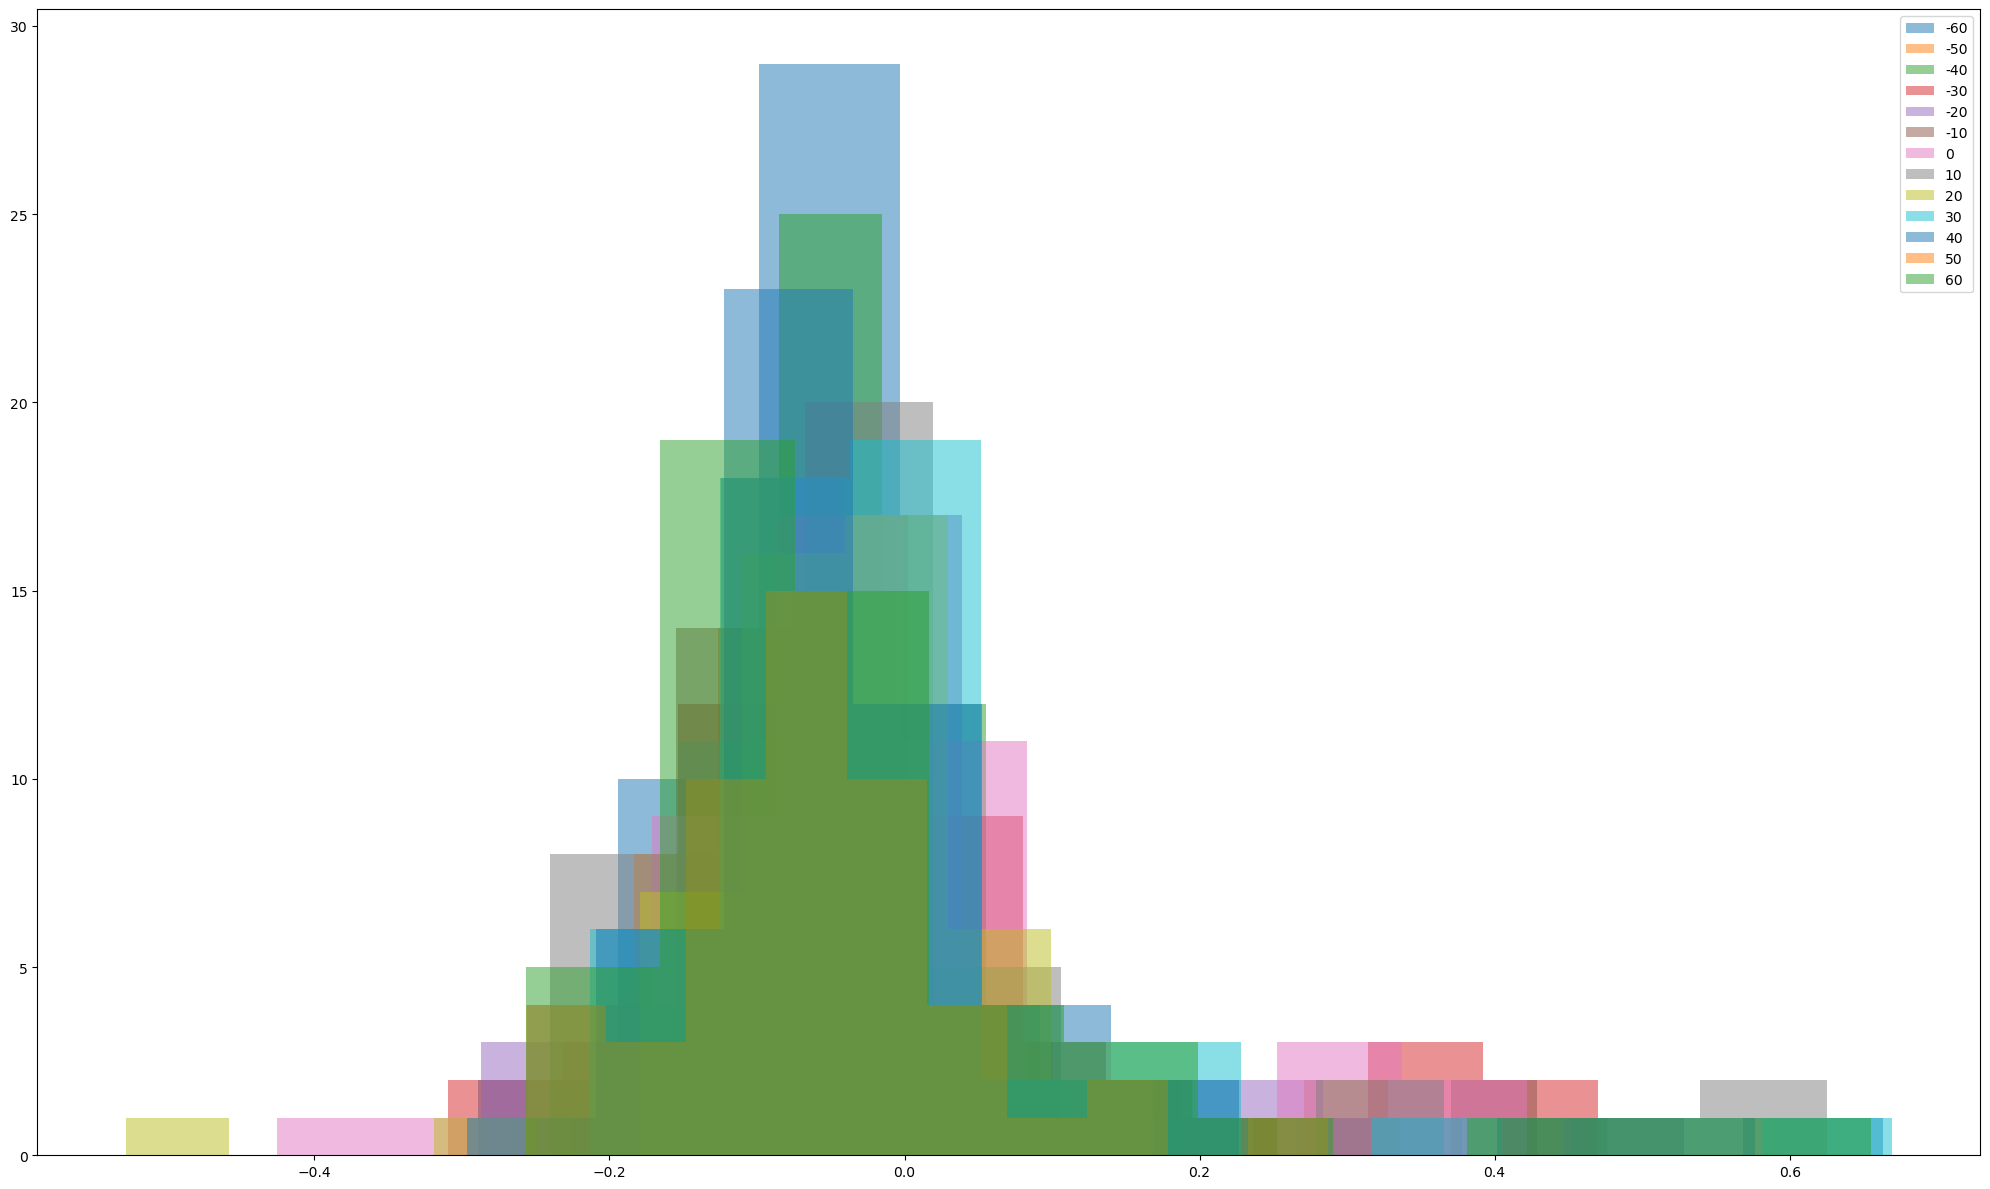

In [453]:

for k in correlation_map.keys():
    plt.hist(correlation_map[k], label=k, alpha=.5)

plt.legend()
plt.show()

In [454]:
import seaborn as sns

In [458]:
df = pd.DataFrame(correlation_map)

<Axes: ylabel='Density'>

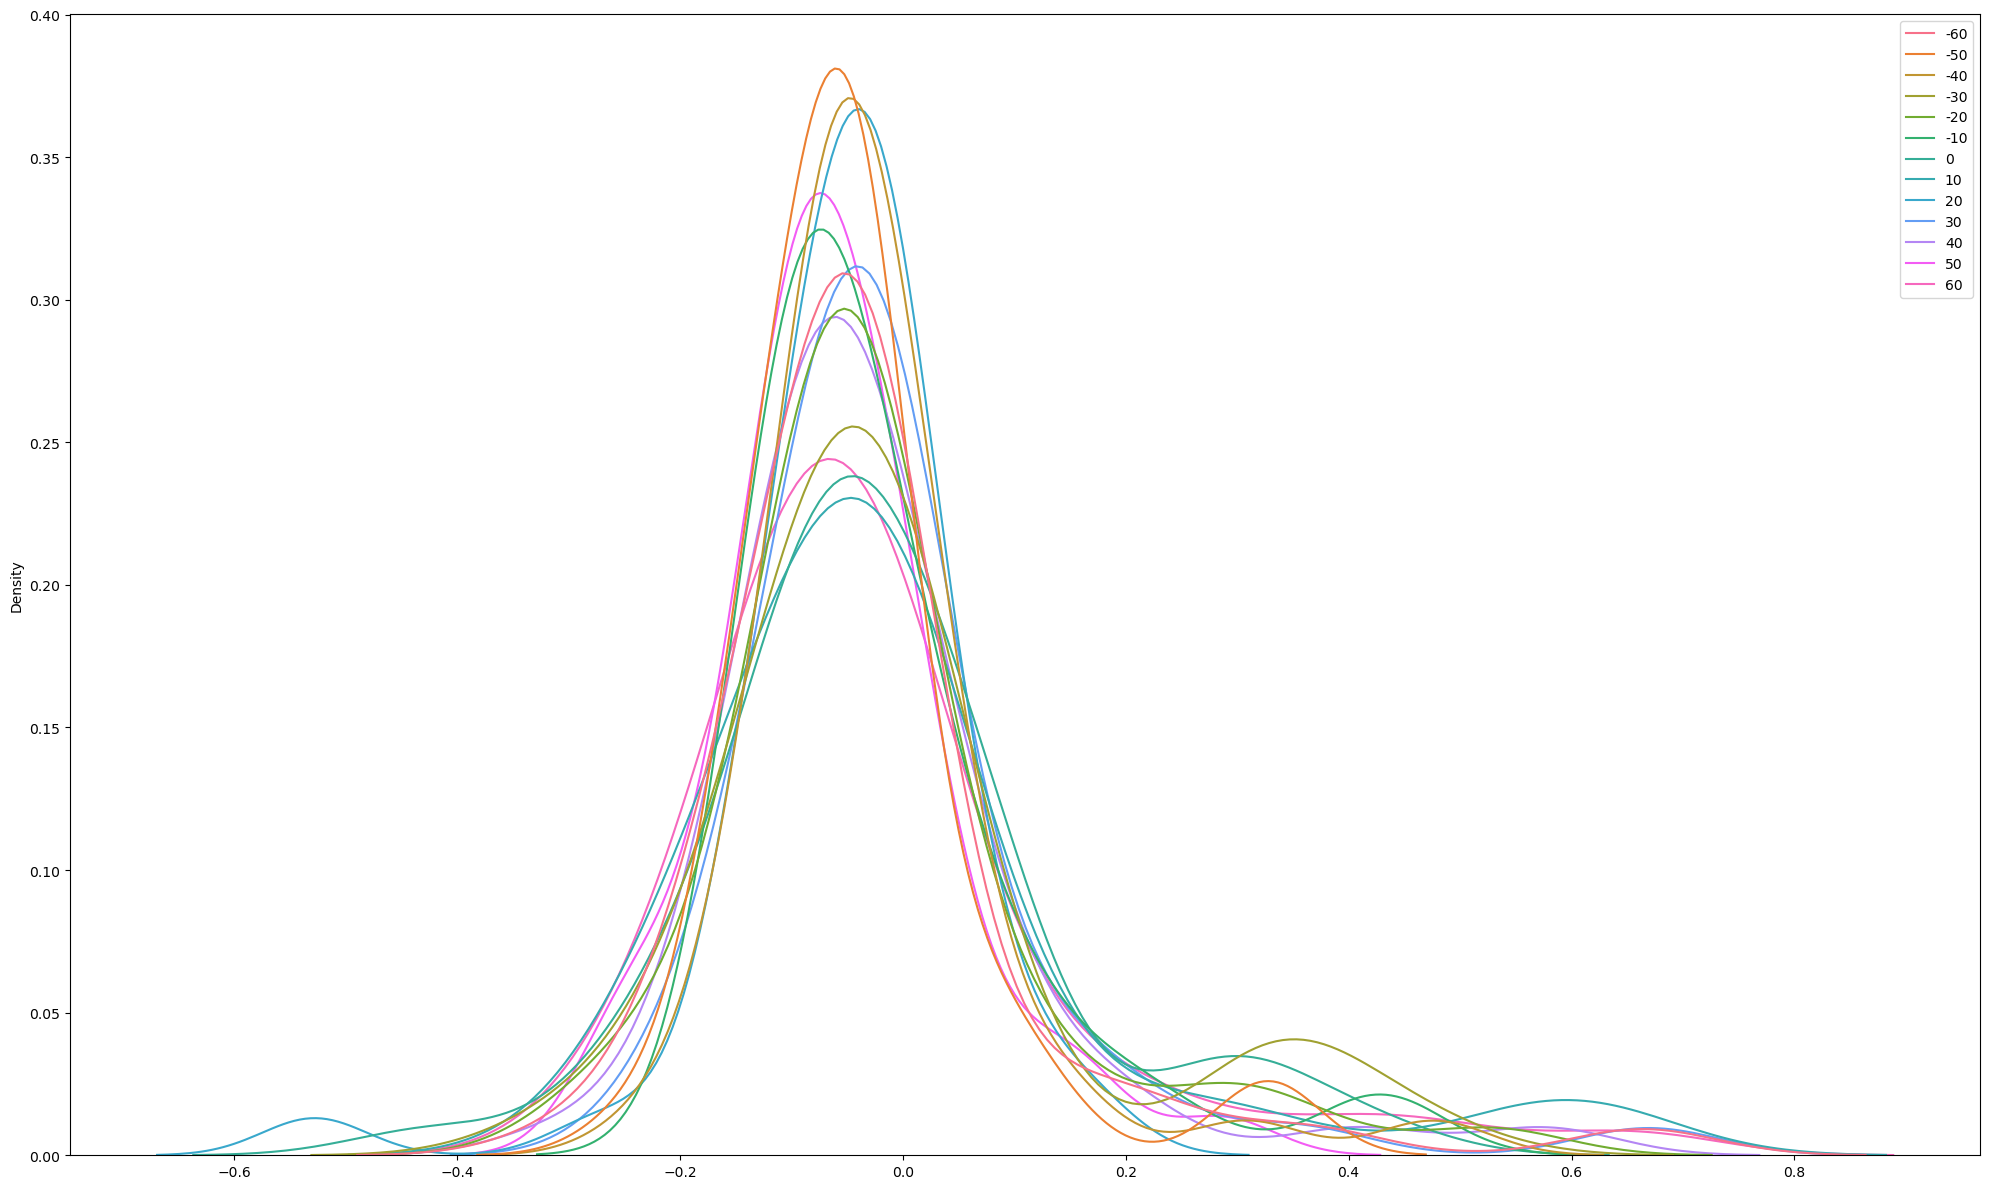

In [459]:
sns.kdeplot(data=df)


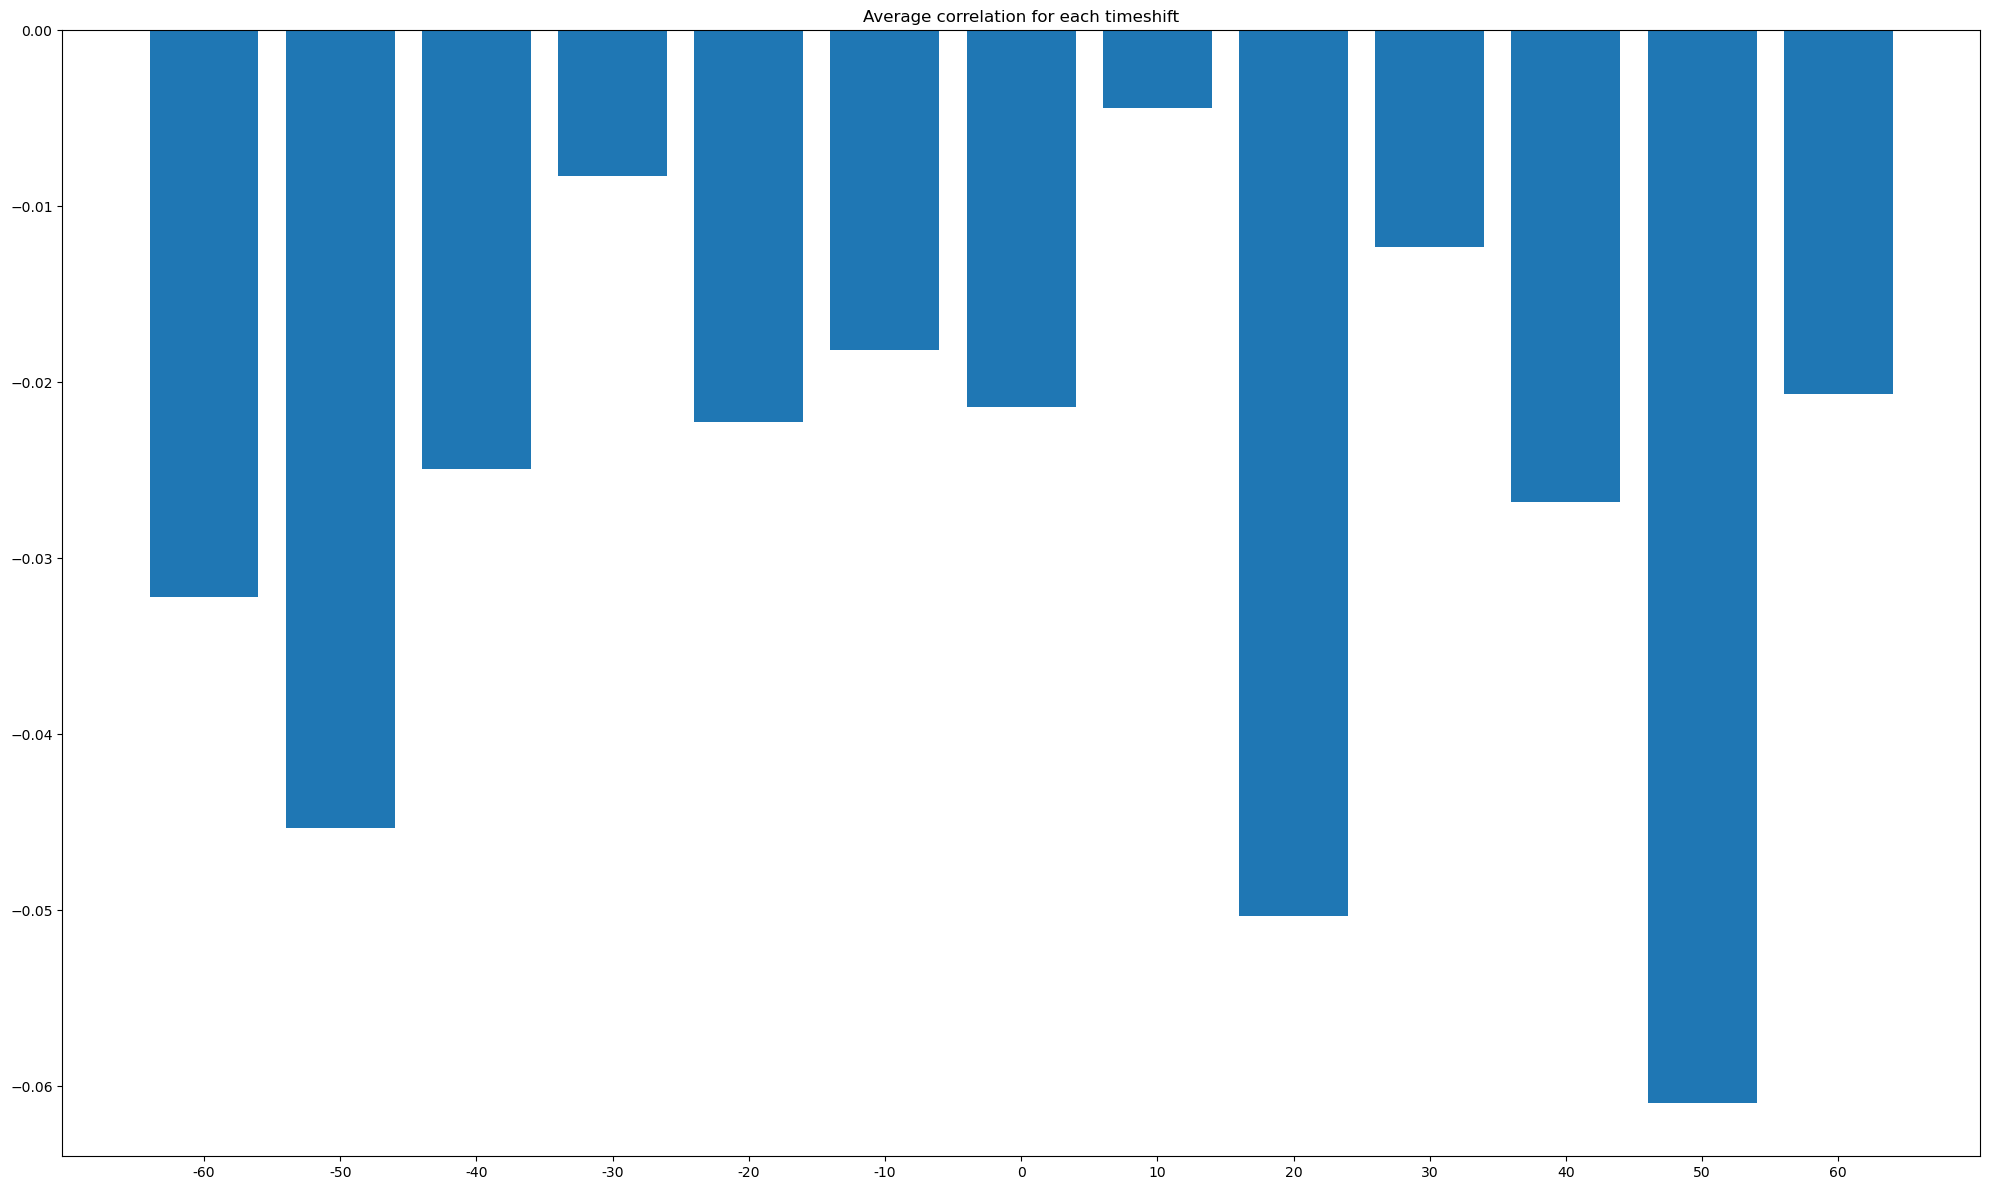

In [470]:
corr_avg = {}
for k, v in correlation_map.items():
    corr_avg[k] = np.mean(v)

names = list(corr_avg.keys())
values = list(corr_avg.values())

plt.bar(range(len(corr_avg)), values, tick_label=names)
plt.title("Average correlation for each timeshift")
plt.show()

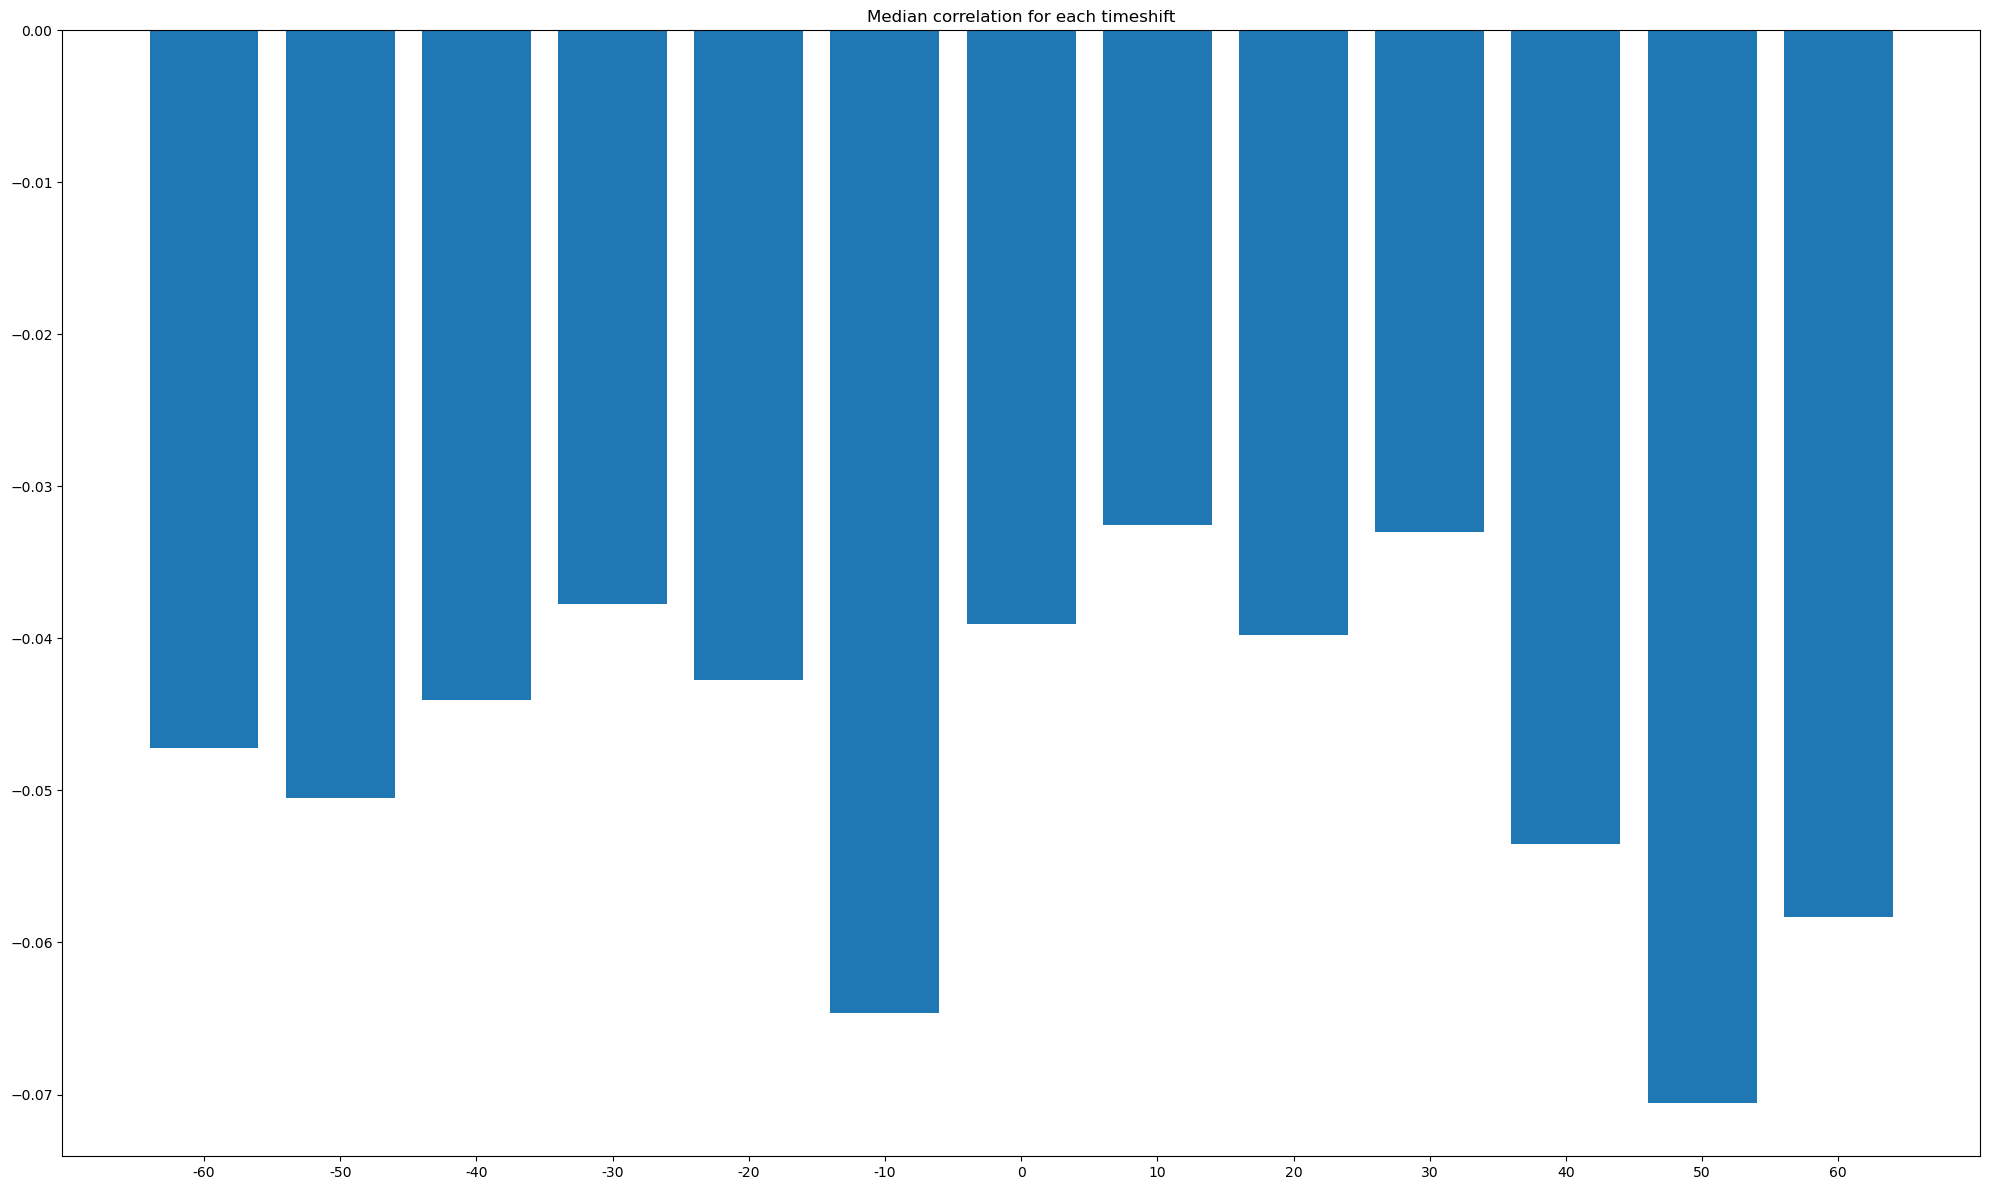

In [472]:
corr_med = {}
for k, v in correlation_map.items():
    corr_med[k] = np.median(v)

names = list(corr_med.keys())
values = list(corr_med.values())

plt.bar(range(len(corr_med)), values, tick_label=names)
plt.title("Median correlation for each timeshift")
plt.show()

In [473]:
tracks_data

MMSI                 1          205700000  212348000  235060304  235076283  \
BaseDateTime                                                                 
2020-01-01 00:00:00        0.0   0.000000        0.0        0.0        0.0   
2020-01-01 00:10:00        0.0   0.000000        0.0        0.0        0.0   
2020-01-01 00:20:00        0.0   0.000000        0.0        0.0        0.0   
2020-01-01 00:30:00        0.0   3.665116        0.0        0.0        0.0   
2020-01-01 00:40:00        0.0   0.000000        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2020-01-03 00:00:00        0.0   0.000000        0.0        0.0        0.0   
2020-01-03 00:10:00      251.3   0.000000        0.0        0.0        0.0   
2020-01-03 00:20:00        0.0   0.000000        0.0        0.0        0.0   
2020-01-03 00:30:00      251.3   0.000000        0.0        0.0        0.0   
2020-01-03 00:40:00      251.3   0.000000        0.0        0.0        0.0   

MMSI                 235554000  303294000  305034000  309046000  309286000  \
BaseDateTime                                                                 
2020-01-01 00:00:00  26.065217        0.0        0.0   0.000000   2.413043   
2020-01-01 00:10:00  31.720930        0.0        0.0   6.146512   0.000000   
2020-01-01 00:20:00  23.485714        0.0        0.0   0.000000   0.000000   
2020-01-01 00:30:00  31.627907        0.0        0.0   0.000000   0.000000   
2020-01-01 00:40:00  26.675676        0.0        0.0   7.143243   0.000000   
...                        ...        ...        ...        ...        ...   
2020-01-03 00:00:00   0.000000        0.0        0.0   0.000000   0.000000   
2020-01-03 00:10:00   0.000000        0.0        0.0   0.000000   0.000000   
2020-01-03 00:20:00   0.000000        0.0        0.0   0.000000   0.000000   
2020-01-03 00:30:00   0.000000        0.0        0.0   0.000000   0.000000   
2020-01-03 00:40:00   0.000000        0.0        0.0   0.000000   0.000000   

MMSI                 ...  563025600  563033000  577364000  636010677  \
BaseDateTime         ...                                               
2020-01-01 00:00:00  ...        0.0   0.000000        0.0        0.0   
2020-01-01 00:10:00  ...        0.0   0.000000        0.0        0.0   
2020-01-01 00:20:00  ...        0.0   0.000000        0.0        0.0   
2020-01-01 00:30:00  ...        0.0   0.000000        0.0        0.0   
2020-01-01 00:40:00  ...        0.0   2.159459        0.0        0.0   
...                  ...        ...        ...        ...        ...   
2020-01-03 00:00:00  ...        0.0   0.000000        0.0        0.0   
2020-01-03 00:10:00  ...        0.0   0.000000        0.0        0.0   
2020-01-03 00:20:00  ...        0.0   0.000000        0.0        0.0   
2020-01-03 00:30:00  ...        0.0   0.000000        0.0        0.0   
2020-01-03 00:40:00  ...        0.0   0.000000        0.0        0.0   

MMSI                 636013644  636015052  636015359  636017731  636018146  \
BaseDateTime                                                                 
2020-01-01 00:00:00  20.002174   8.404348        0.0        0.0        0.0   
2020-01-01 00:10:00  16.834884  13.937209        0.0        0.0        0.0   
2020-01-01 00:20:00  17.488571  19.257143        0.0        0.0        0.0   
2020-01-01 00:30:00  21.930233  19.306977        0.0        0.0        0.0   
2020-01-01 00:40:00  17.978378   9.151351        0.0        0.0        0.0   
...                        ...        ...        ...        ...        ...   
2020-01-03 00:00:00   0.000000   0.000000        0.0        0.0        0.0   
2020-01-03 00:10:00   0.000000   0.000000        0.0        0.0        0.0   
2020-01-03 00:20:00   0.000000   0.000000        0.0        0.0        0.0   
2020-01-03 00:30:00   0.000000   0.000000        0.0        0.0        0.0   
2020-01-03 00:40:00   0.000000   0.000000        0.0        0.0        0.0   

MMSI              

# Problem  
I messed up the binning of the timestamps and COG values. By creating one dataframe with all timestamps and filling the missing timestamps with 0, this essentially added a layer of random noise to the original data. I need to bin the data for each track into (2 minute?) intervals and then combine all the tracks into a single dataframe, once they all have the same bins. Essentially, the COG values for each track should only be based on that track, not data from other tracks. Here is a rough plan of action:  
1. Take the original dataframe and for each MMSI, bin the average COG values together in 2 minute buckets so that each track shares the identical timestamps.
2. Interpolate missing data by using a linear interpolation method between closest values. 
3. Join all the separate transformed tracks together into a single dataframe.
4. Pivot the dataframe so that each track is a column.
5. Redo analysis

# Important Notes  
1. Why do we have these very sparse records? What would this indicate? Do we assume the ship is moving furing this time or are staying in the same location? Perhaps it would be better to use lat, lon if we can assume that when a ship doesn't report it's AIS it is just remaining in the same location. Ask Nick, if the AIS is not sent, does this usually mean the ship is staying put?
2. When a ship is not moving, it's COG is zero. This suggests that missing timestamps, especially if they are sparse, should have a COG value of zero.
3. I think the best solution to this problem would be to clean the data to have clean tracks. For instance, if a ship has a grouping of timestamps over the course of an hour, then no activity for a few hours, than another grouping of timestamps, this should be broken into two timestamps.
4. Strategy (1) seems to work well but significantly reduces the data. I think a better solution in the long term would be to devise a system for extracting tracks so we have less missing data.
5. To put all tracks on the same index, in the end each track will have zeros for when they are not moving. Does this make sense?

## Plan of Action:  
We want to find all the tracks in our full data that make a "good" track. We define a good track as being dense. A dense track consists of two things, (1) many observations inside 2 minute windows and (2) very few null 2 minute windows as a proportion of the total track. We need to devise a way to systematically extract good tracks out of our data. Here is an outline of the proposed procedure:  
1. For a single ship track, find clusters such that the records are close together in time. 

In [474]:
# Original (partially cleaned) data
la_data.head()

MMSI        BaseDateTime       LAT        LON  SOG    COG  Heading
33182  309955000 2020-01-02 09:16:32  33.76889 -118.25191  0.1   92.4    218.0
33183  309955000 2020-01-02 09:15:02  33.76882 -118.25191  0.1  341.0    219.0
33184  309955000 2020-01-02 09:13:32  33.76882 -118.25183  0.1  204.7    217.0
33186  309955000 2020-01-02 09:11:11  33.76884 -118.25177  0.1  261.3    217.0
33187  309955000 2020-01-02 09:10:02  33.76885 -118.25170  0.1  269.7    216.0

In [1576]:
sample = la_data[la_data.MMSI==mmsi].sort_values("BaseDateTime")

In [1577]:
multiple_tracks = [367006790, 636013644, 577364000]

In [1579]:
sample = sample.set_index("BaseDateTime")

In [1580]:
pd.set_option('display.max_rows', None)

### Cleaning Track Data  


In [1632]:
tracks = []
for mmsi in la_data.MMSI.unique():
    track = la_data[la_data.MMSI==mmsi].sort_values("BaseDateTime")
    track = track.set_index("BaseDateTime")
    track['time_diff'] = track.index.to_series().diff().dt.seconds.div(60, fill_value=0)
    if track.time_diff.mean() < 2.0:
        track = track.drop(["time_diff"], axis=1)
        track = track.resample("3T").mean().interpolate()
        tracks.append(track)
    else:
        la_data = la_data[la_data.MMSI != mmsi]

27

## Strategy 1

In [618]:
mmsi = la_data.MMSI.sample(1).values[0]
sample = la_data[la_data.MMSI == mmsi]

In [632]:
abs(sample.BaseDateTime.diff().dt.total_seconds().min()) / 60

195.0

In [634]:
all_mmsi = la_data.MMSI.unique()

In [670]:
viable_mmsi = []
for mmsi in all_mmsi:
    sample = la_data[la_data.MMSI == mmsi]
    max_delta = abs(sample.BaseDateTime.diff().dt.total_seconds().min()) / 60
    if max_delta < 15:
        viable_mmsi.append(mmsi)
viable_mmsi

[309955000,
 354899000,
 366799000,
 305034000,
 477287000,
 366508000,
 416498000,
 636017731,
 235060304]

In [707]:
viable_la_data = la_data[la_data.MMSI.isin(viable_mmsi)].reset_index()

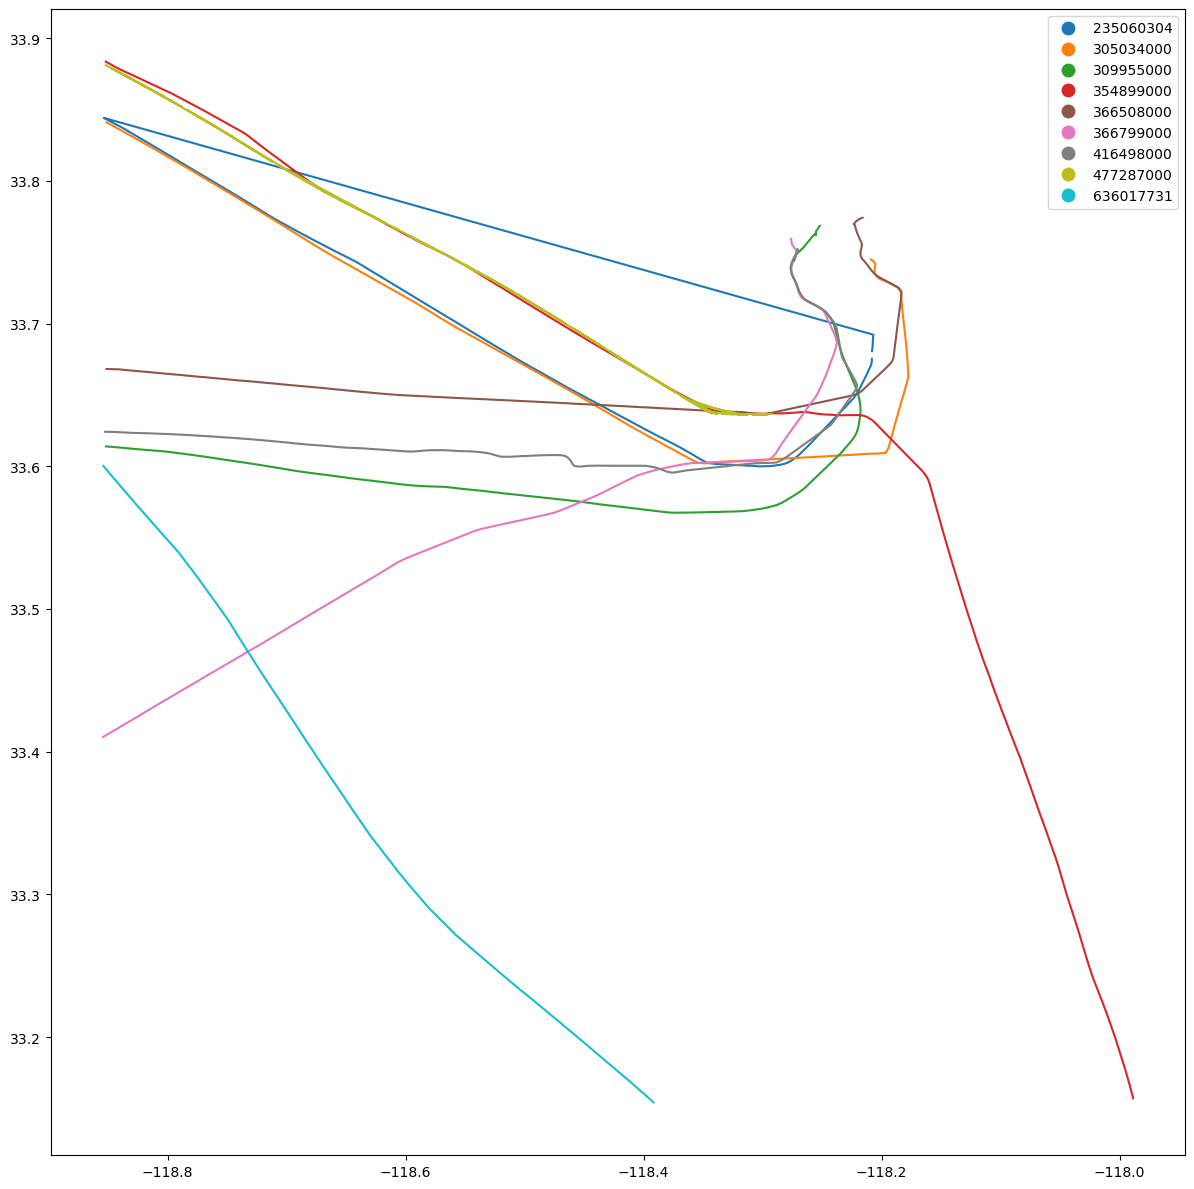

In [708]:
draw_tracks(viable_la_data, viable_mmsi)

In [709]:
len(la_data.MMSI.unique())

57

In [710]:
prop_null = []
for mmsi in viable_mmsi:
    sample = la_data[la_data.MMSI == mmsi]
    sample = sample.set_index("BaseDateTime")
    sample = sample.resample("2T").mean()
    prop_null.append(np.count_nonzero(sample.isna().COG.values) / sample.shape[0])

In [711]:
viable_la_data[viable_la_data.MMSI == 309955000].interpolate()

index       MMSI        BaseDateTime       LAT        LON  SOG    COG  \
0    33182  309955000 2020-01-02 09:16:32  33.76889 -118.25191  0.1   92.4   
1    33183  309955000 2020-01-02 09:15:02  33.76882 -118.25191  0.1  341.0   
2    33184  309955000 2020-01-02 09:13:32  33.76882 -118.25183  0.1  204.7   
3    33186  309955000 2020-01-02 09:11:11  33.76884 -118.25177  0.1  261.3   
4    33187  309955000 2020-01-02 09:10:02  33.76885 -118.25170  0.1  269.7   
..     ...        ...                 ...       ...        ...  ...    ...   
248  33432  309955000 2020-01-02 03:15:50  33.61272 -118.83527  8.1   95.4   
249  33433  309955000 2020-01-02 03:14:01  33.61309 -118.84017  8.0   94.9   
250  33434  309955000 2020-01-02 03:12:11  33.61345 -118.84515  8.0   94.7   
251  33435  309955000 2020-01-02 03:11:01  33.61367 -118.84830  8.0   94.9   
252  33436  309955000 2020-01-02 03:09:21  33.61397 -118.85273  8.1   94.4   

     Heading  
0      218.0  
1      219.0  
2      217.0  
3      217.0  
4      216.0  
..       ...  
248     97.0  
249     97.0  
250     97.0  
251     97.0  
252     97.0  

[253 rows x 8 columns]

In [722]:
clean_tracks = []
for mmsi in viable_mmsi:
    clean_tracks.append(viable_la_data[viable_la_data.MMSI == mmsi].interpolate())
viable_la_data = pd.concat(clean_tracks)